In [1]:
# AeroCNN-II with U-Net
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9815364050690311775
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22722641920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10947984554685618249
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 22722641920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7300578245490806223
 physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6"
 xla_global_id: 2144165316,
 name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 22722641920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7250613883552386236
 physical_device_desc: "device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:61:00.0, compute capability: 8.6"
 xla_global_

In [3]:
mirrored_strategy = tf.distribute.MirroredStrategy(["/GPU:0","/GPU:1", "/GPU:2"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


In [4]:
n_kernel=50
l2Regularizer=1e-09
kernel_size1 = 5
kernel_size2 = 5
#kernel_size3 = 5
n_grid = 101
strides = 1
input_size = 100

In [5]:
alpha = np.linspace(-10,10,11).reshape((-1,1))

In [6]:
aa = np.zeros((11*133,1))
for i in range(0, 133):
    aa[11*i:11*(i+1), :] = alpha[:,:]

In [7]:
aa = aa.reshape((133, 11, 1, 1))

In [8]:
os.chdir('D:\\AeroCNN2Inputs')

In [9]:
origin = "D:\\AeroCNN2Inputs"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [10]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [11]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "_alpha"+ str(int(alpha[j])) + ".csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [12]:
image_np = image_df.iloc[:, :].values

In [13]:
image = image_np.reshape((133, 11, 100, 100))

In [14]:
image = 1-image/100

In [15]:
path = 'D:\\airfoilFlowField'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')]

In [16]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 0].values

In [17]:
data_name = path + '\\' + str(geometry_orig[0]) + "alpha"+ str(int(alpha[1])) + "_interpolated.csv"
print(data_name)

D:\airfoilFlowField\airfoil1alpha-8_interpolated.csv


In [18]:
Vmag_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        data_name = path + '\\' + str(geometry_orig[i-1]) + "alpha"+ str(int(alpha[j])) + "_interpolated.csv"
        data = pd.read_csv(data_name, header=None)
        Vmag_df = pd.concat([Vmag_df, data], axis=0)

In [19]:
geometry_orig = airfoilName_df.iloc[:, 1].values

In [20]:
y_imp = Vmag_df.iloc[:, :].values

In [21]:
y = y_imp.reshape((133, 11, n_grid, n_grid))

In [22]:
geometry = np.zeros((133*11,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,11):
        geometry[11*index_[0]+j,:] = np.asarray(i)

In [23]:
geometry.shape

(1463, 1)

In [24]:
geometry = geometry.reshape((133, 11, 1))

In [25]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(image, aa, geometry, y, test_size=0.05, random_state=1)

In [26]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [29]:
os.chdir('D:\\TrainedModels\\20221019')

In [30]:
sd = tf.keras.models.load_model('AeroCNN-II_with_U-net_FlowFieldPrediction_50kernel_2by2MaxPooling_1CNNlayer_testSize0.05(-10to10).h5')

In [32]:
with mirrored_strategy.scope():
    test_results = sd.evaluate(x_train)
    decoded_train = sd.predict(x_train)
    decoded_test = sd.predict(x_test)

3/3 [==============================] - 0s 106ms/step


In [34]:
test_results2 = sd.evaluate(x_test)

3/3 [==============================] - 0s 47ms/step - loss: 2.4740e-05 - rmse: 0.0000e+00


In [35]:
y_train.shape

(1386, 101, 101)

In [36]:
y_train.shape[0]

1386

In [37]:
type(decoded_train.shape[3])

int

In [38]:
type(decoded_train)

numpy.ndarray

In [39]:
type(n_grid)

int

In [40]:
decoded_train = decoded_train.reshape((int(y_train.shape[0]),int(n_grid),int(n_grid)))
decoded_test = decoded_test.reshape((int(y_test.shape[0]),int(n_grid),int(n_grid)))

In [41]:
decoded_train.shape

(1386, 101, 101)

In [42]:
y_train.shape[0]

1386

In [43]:
error_train_abs = np.abs(decoded_train - y_train)

In [44]:
error_test_abs = np.abs(decoded_test - y_test)

In [45]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [46]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [47]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [48]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [49]:
decoded_train.shape

(1386, 101, 101)

In [52]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.01062082200726628


In [53]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.018070168825046563


In [54]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.013120697971060642, 0.016700776642905858, 0.012249221389776839, 0.008699594517609108, 0.0075221294858429716, 0.008037239693777454, 0.0075776890034555495, 0.007442890736379834, 0.009678122762973723, 0.02260560427784647, 0.024630228952024883, 0.020987953235928374, 0.008374752914023415, 0.008936764388869206, 0.010312878914997712, 0.009350958028195376, 0.009017317566018963, 0.009595701555526926, 0.009398798838862969, 0.010320123728457939, 0.010214412057111167, 0.015114269935979351, 0.014688589778663566, 0.018263069369925226, 0.010972735721594802, 0.009178645142488923, 0.009565626393064458, 0.010664293210615993, 0.010846419645291578, 0.01285240273098058, 0.009775898319084531, 0.01119783926954224, 0.011009787617370507, 0.012238332437271363, 0.009918552654873061, 0.01079272782583096, 0.010244830968313315, 0.008862757964285133, 0.008782269915470377, 0.00888625714959731, 0.00795057210367382, 0.009105412062246746, 0.008058177021259234, 0.007989951508584316, 0.04516820887376818, 0.010793095378

In [55]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.013957751445941939, 0.012961876920256687, 0.008155540892596253, 0.008742110169944231, 0.008846659457024562, 0.00779999533827532, 0.008472952079331048, 0.008338557694846907, 0.008572606070629466, 0.010419467898204996, 0.05084535703750931, 0.016658223552797384, 0.014899074117369324, 0.01638634540283444, 0.016456324813442568, 0.01671511034388749, 0.015084334250863968, 0.015243650274155795, 0.013823125894062167, 0.015073020468490001, 0.015370163693615572, 0.016304145080421335, 0.01997858187684036, 0.013032238542325523, 0.0109978011849508, 0.011022176902476024, 0.011171132356037903, 0.010948919395567363, 0.012259943395895801, 0.012854555301255129, 0.013335284015677826, 0.014111778337748378, 0.04666142885444828, 0.032106285550946495, 0.012265975652616818, 0.00807714424182943, 0.007660181154748193, 0.007520598284403204, 0.007103019615254176, 0.007221959300802634, 0.0074710376015802785, 0.013196662725766615, 0.01768813665351527, 0.03308932443965749, 0.036160437344804224, 0.01761803868565624

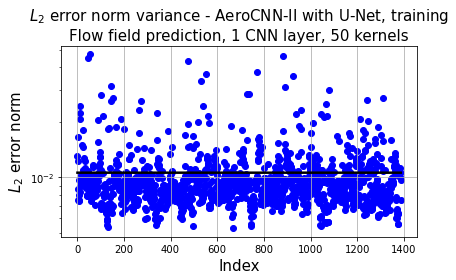

In [56]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II with U-Net, training\nFlow field prediction, 1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

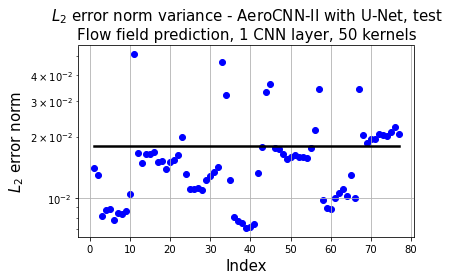

In [57]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II with U-Net, test\nFlow field prediction, 1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [58]:
os.chdir("D:\\AeroCNNII_Images\\20221019")

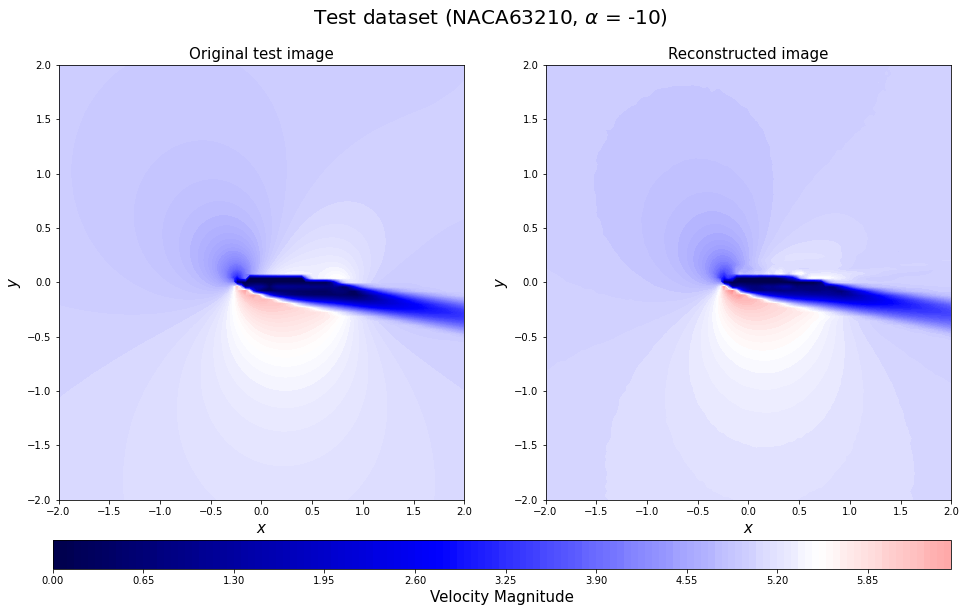

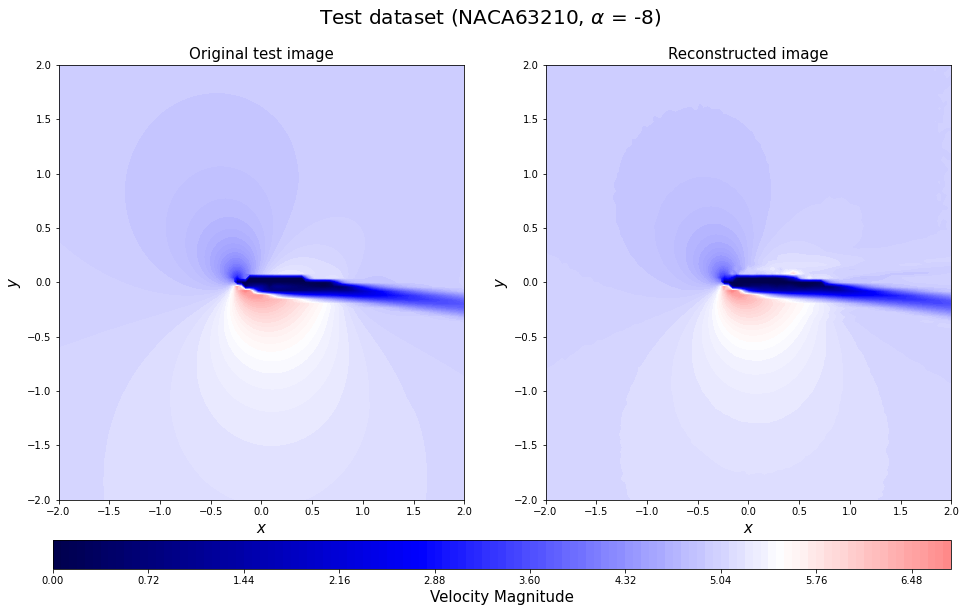

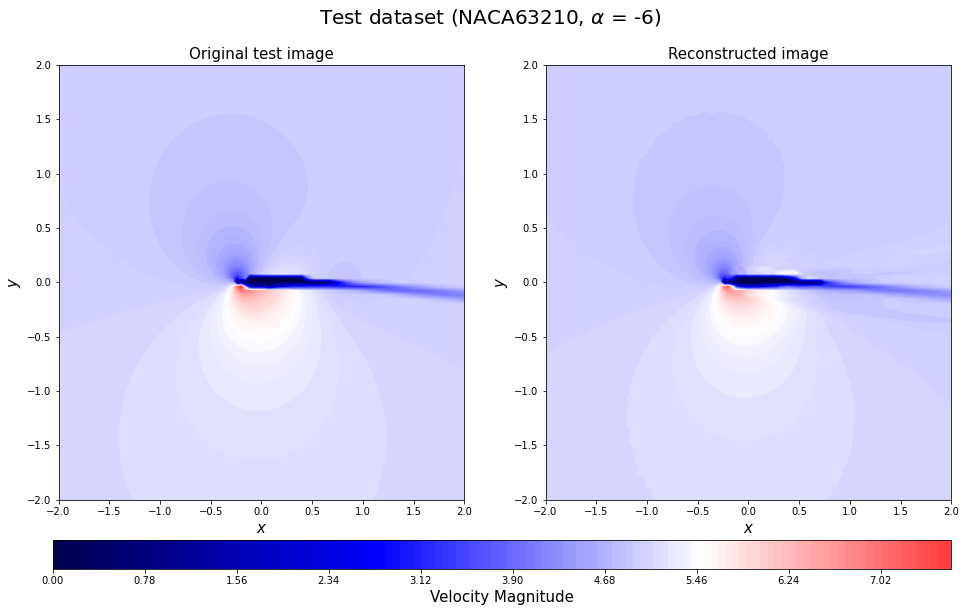

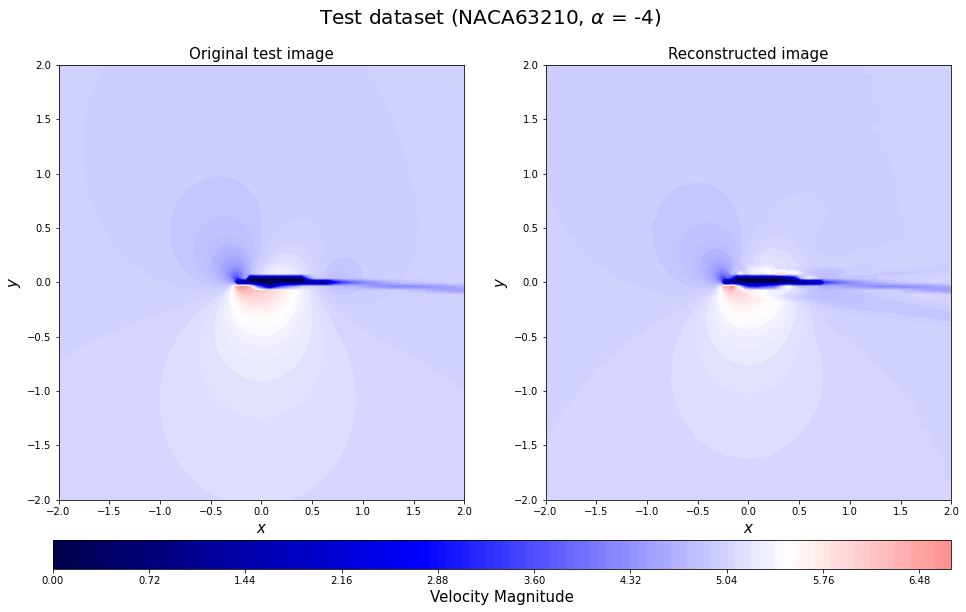

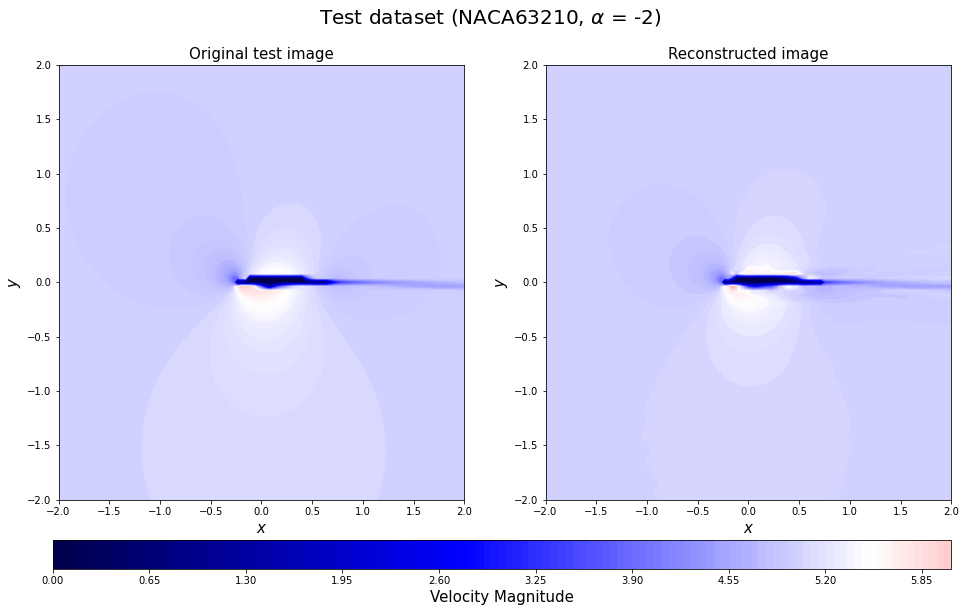

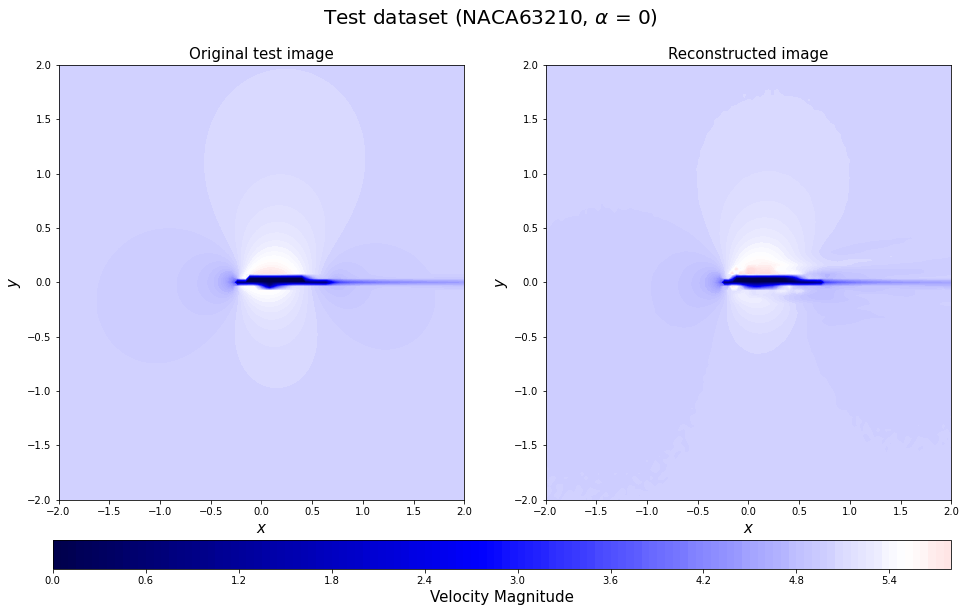

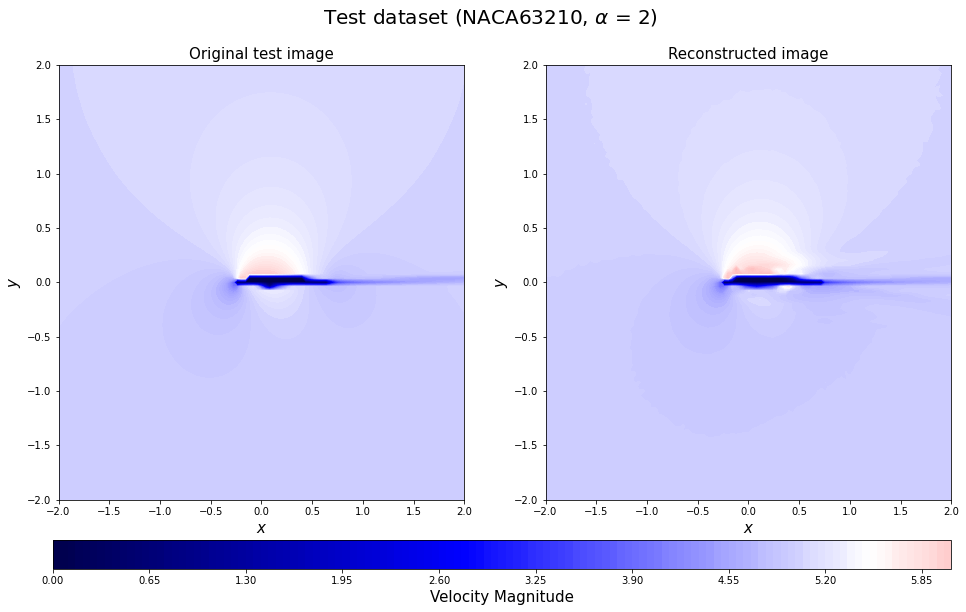

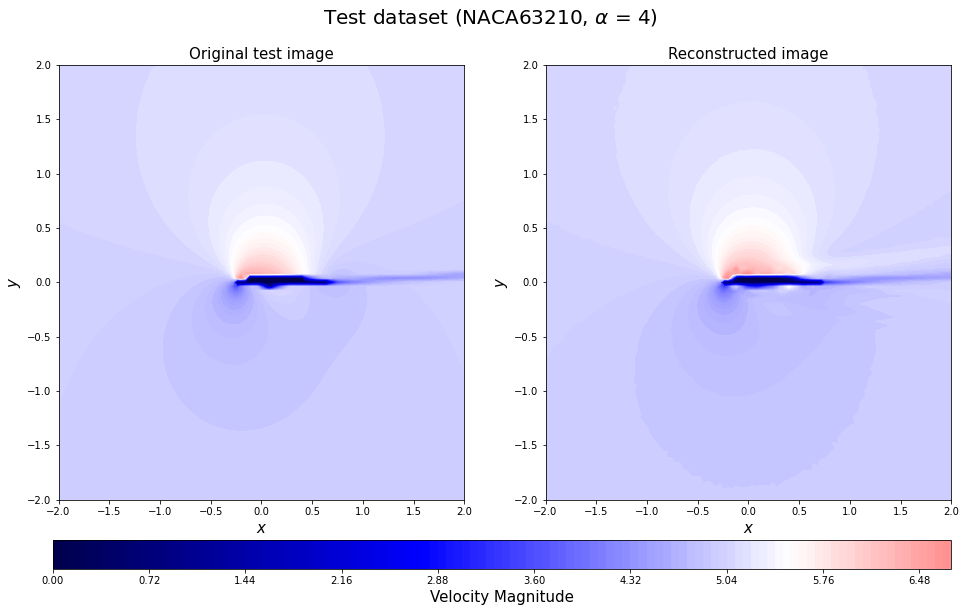

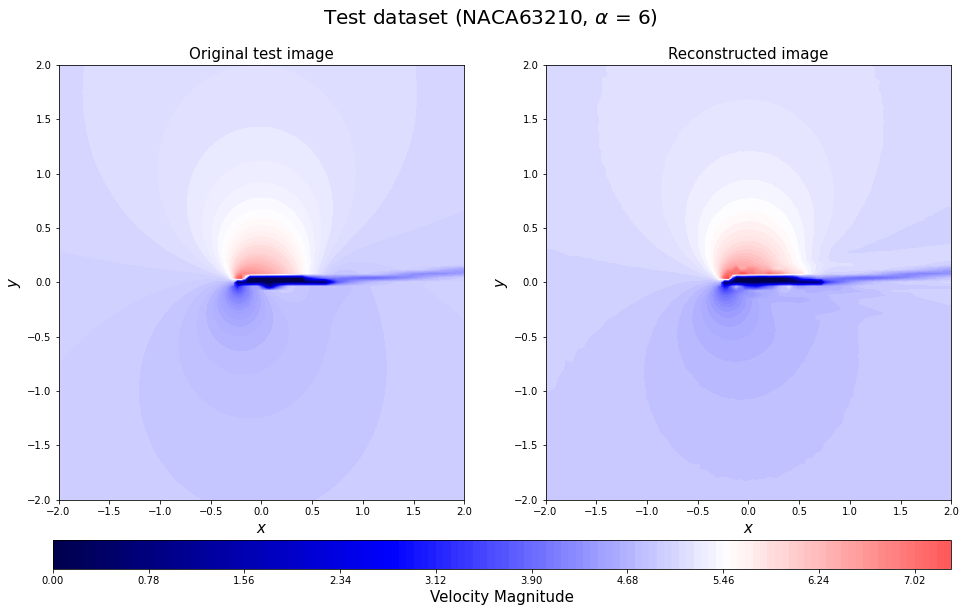

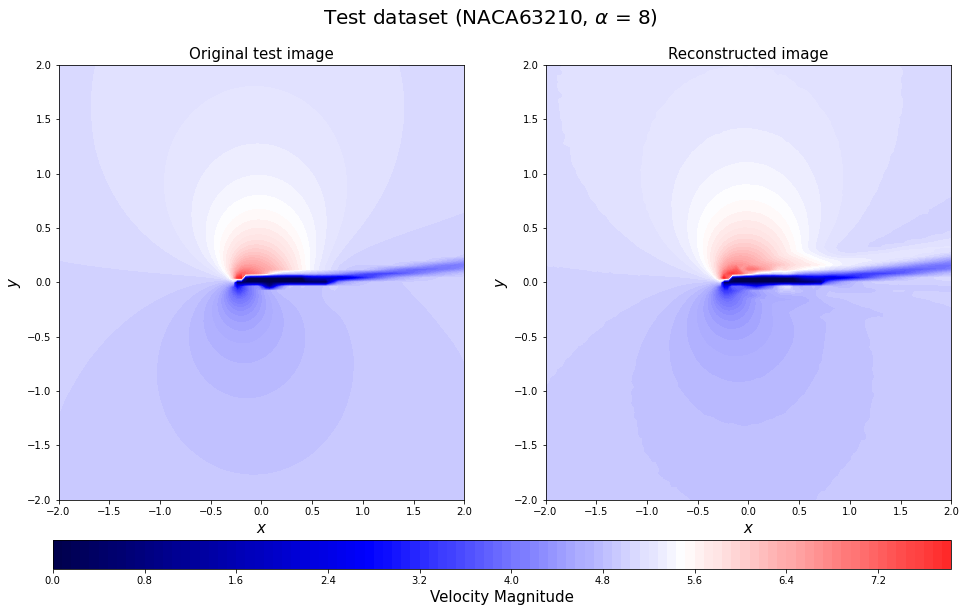

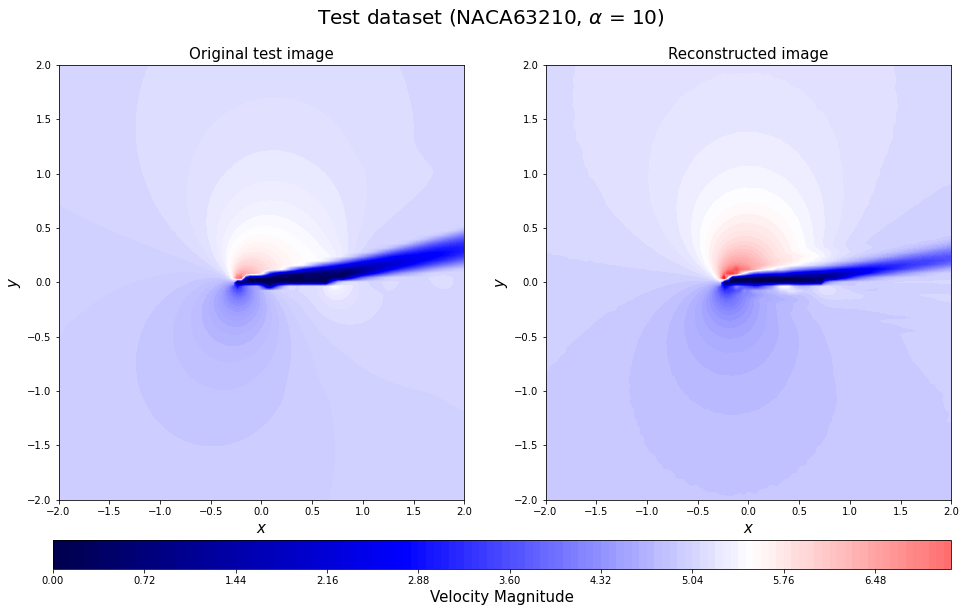

In [59]:
for c in range(0,11):
    plt.figure(figsize=(16, 8))
    y_test2_rotate = y_test[2*11+c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_test[2*11+c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test2_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[2*11+c])[3:-2], aa_test[2*11+c]),fontsize=20)
    save_fig_name = "20221019Prediction_AeroCNN-II(-10to10)(test)"+str(np.array2string(geo_test[2*11+c])[3:-2])+str(aa_test[2*11+c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

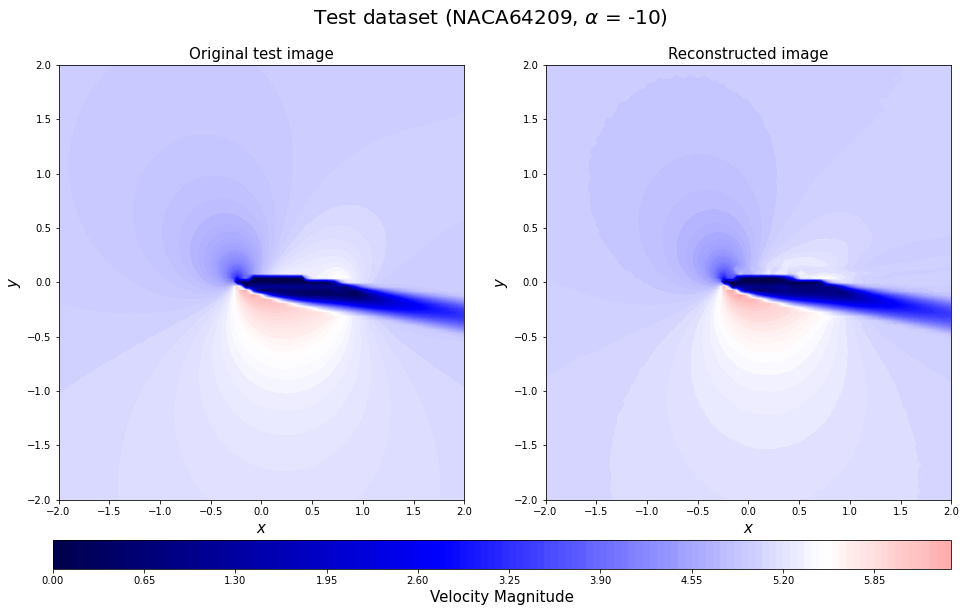

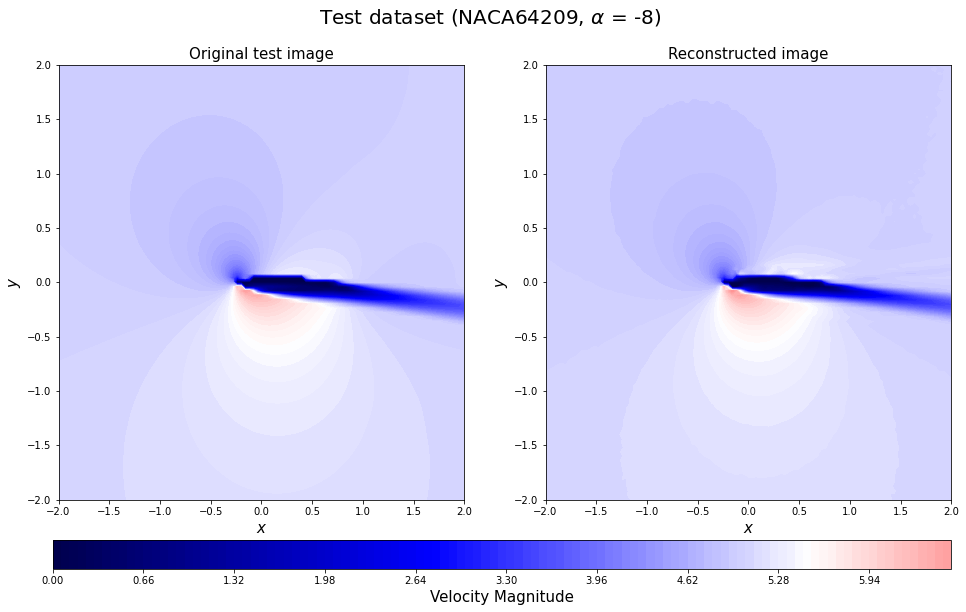

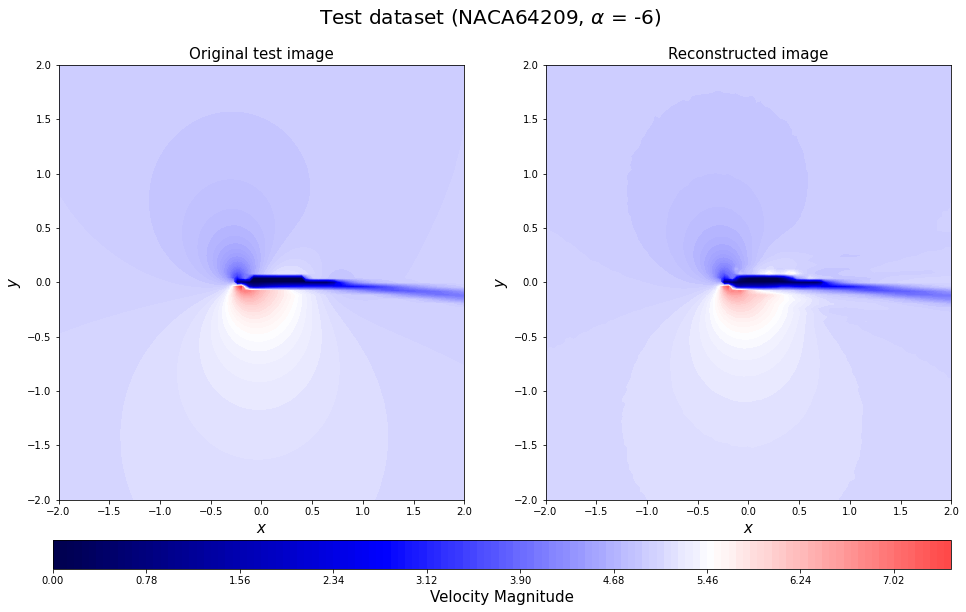

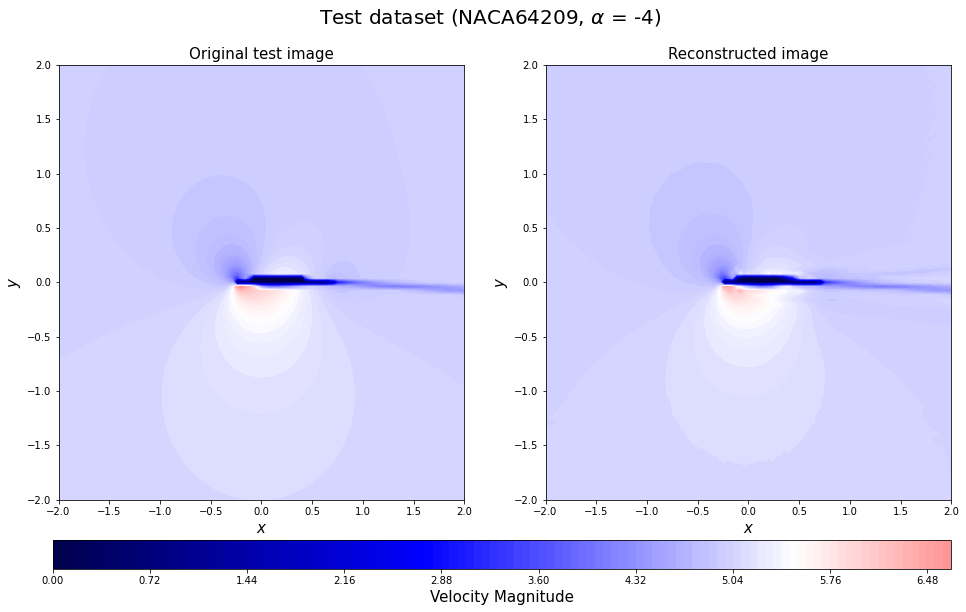

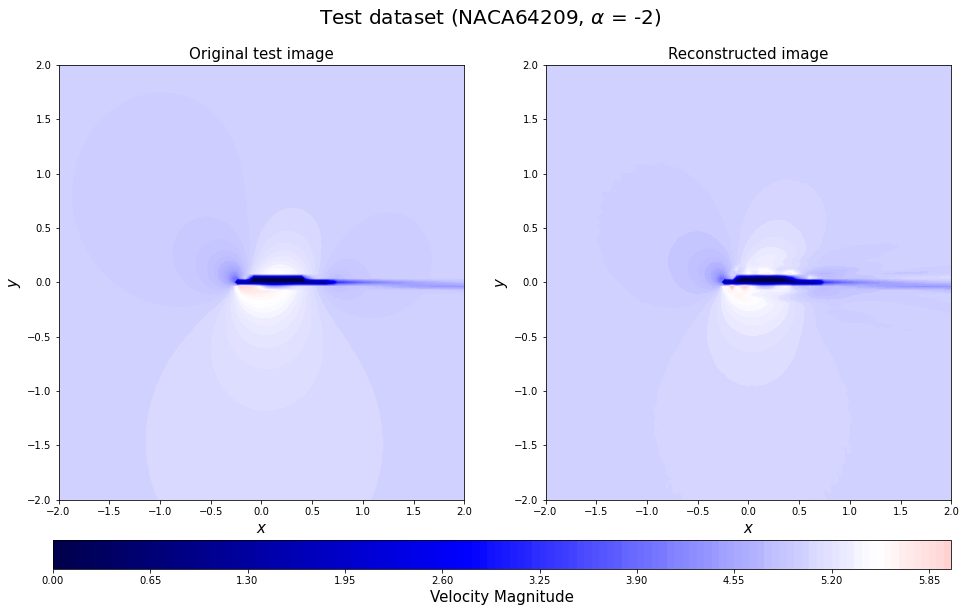

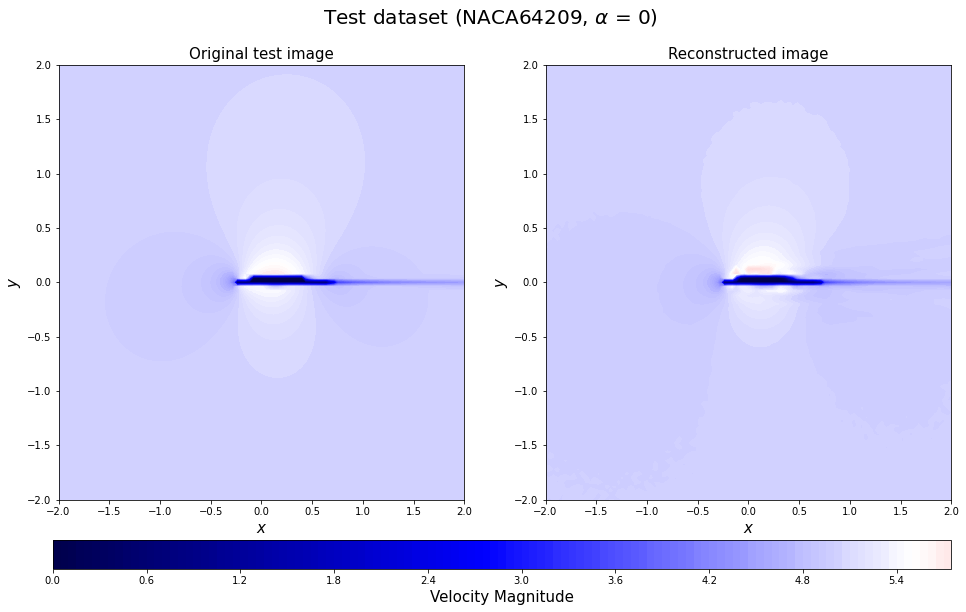

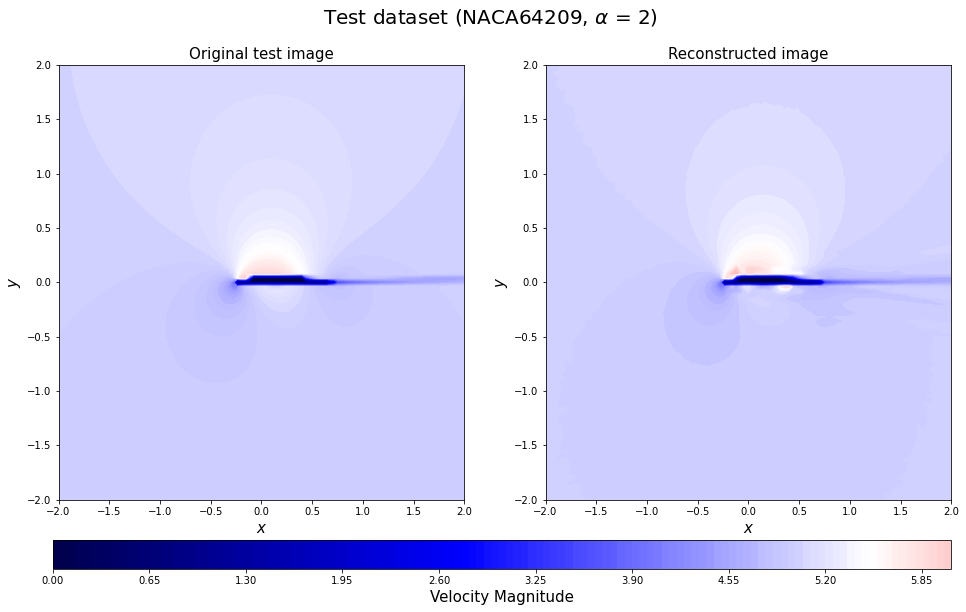

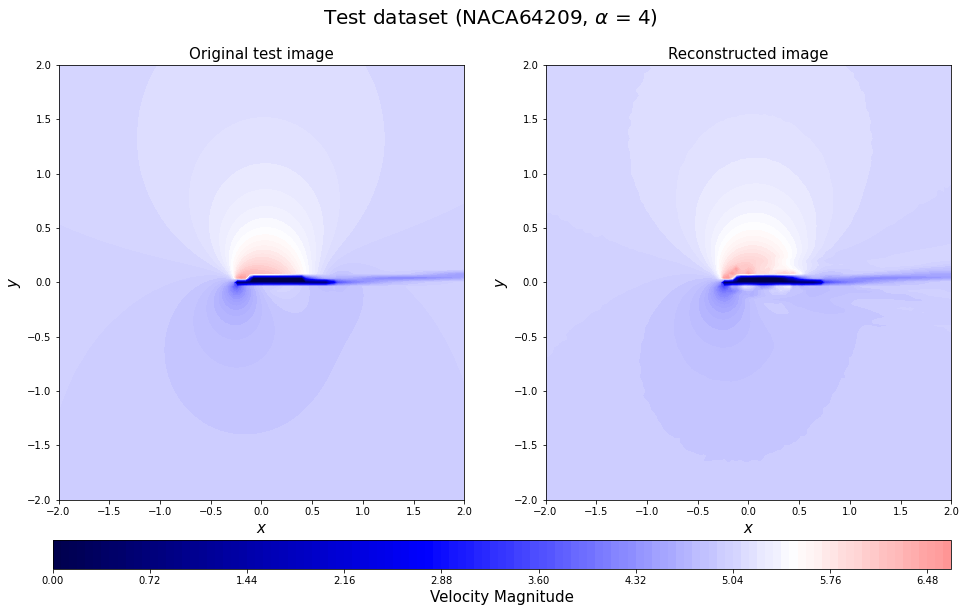

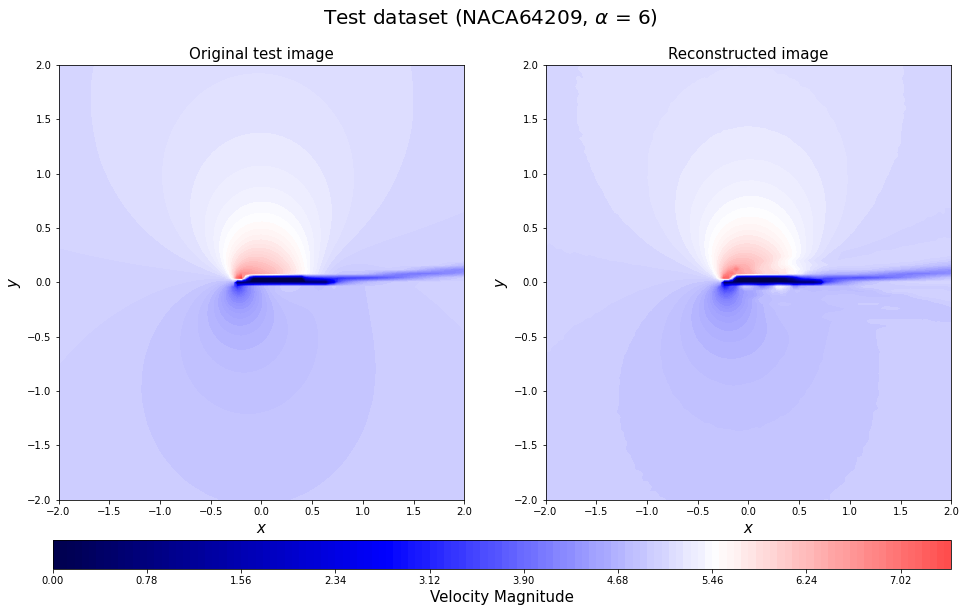

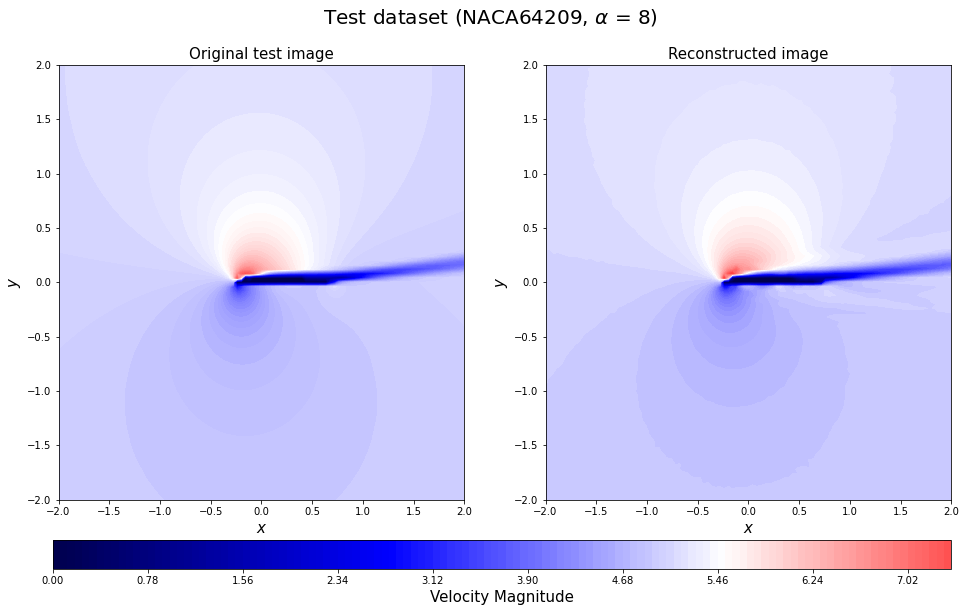

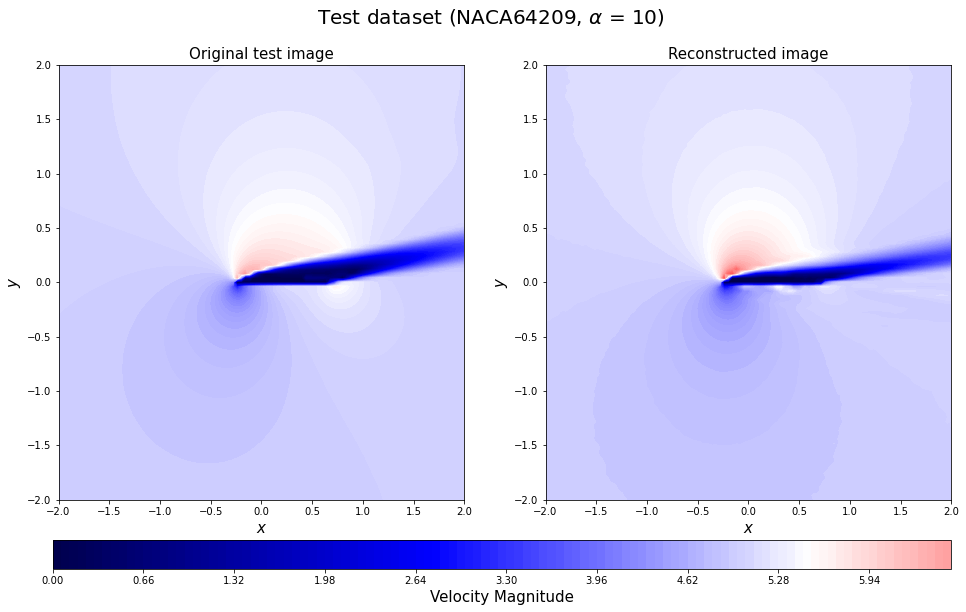

In [60]:
for c in range(0,11):
    plt.figure(figsize=(16, 8))
    y_test0_rotate = y_test[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_test[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test0_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[c])[3:-2], aa_test[c]),fontsize=20)
    save_fig_name = "20221019Prediction_AeroCNN-II(-10to10)(test)"+str(np.array2string(geo_test[c])[3:-2])+str(aa_test[c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

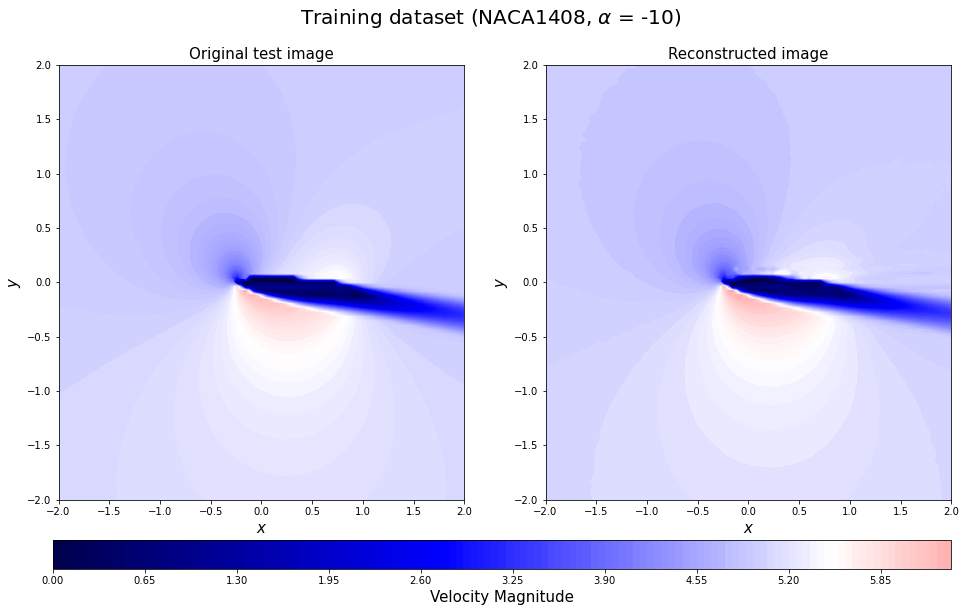

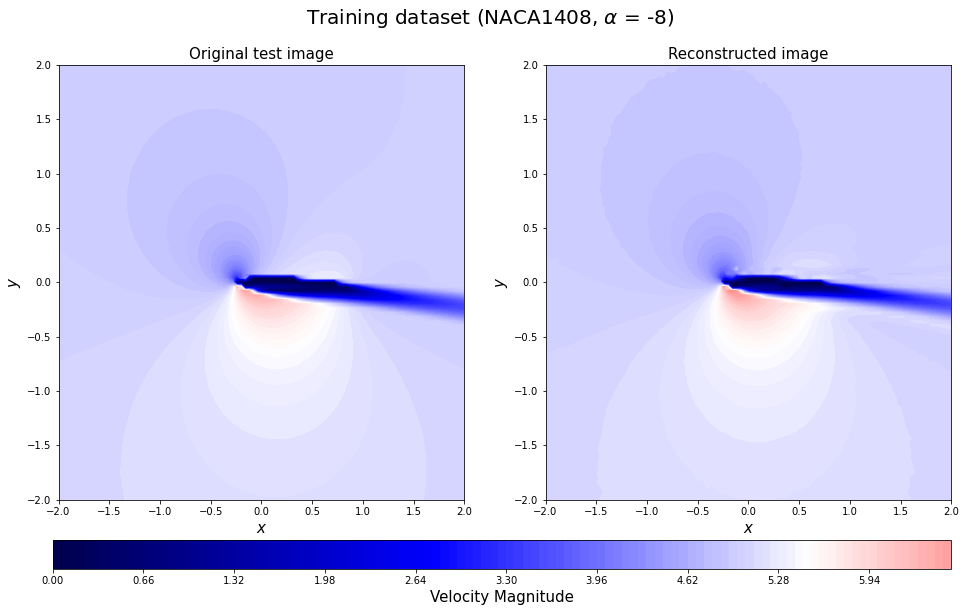

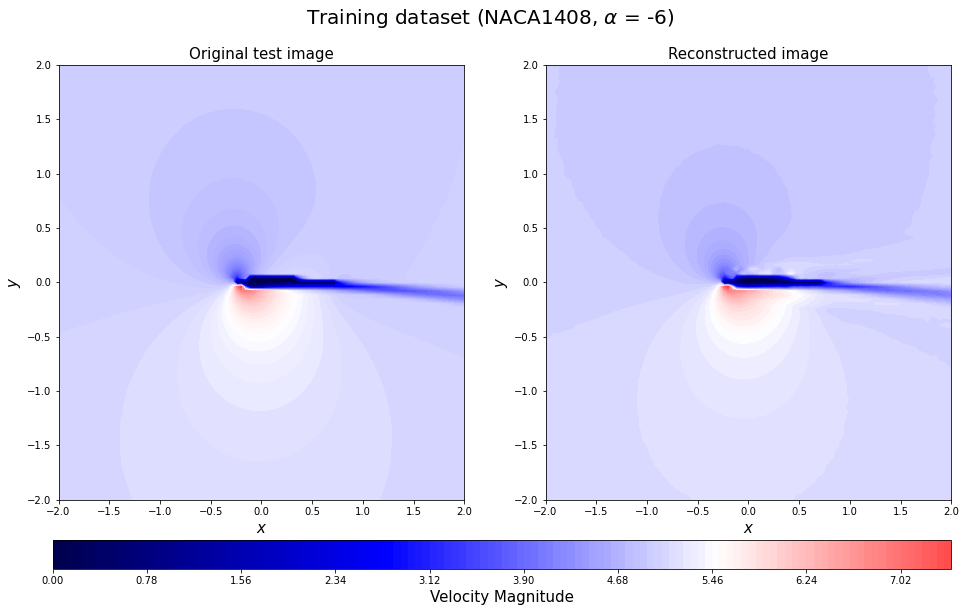

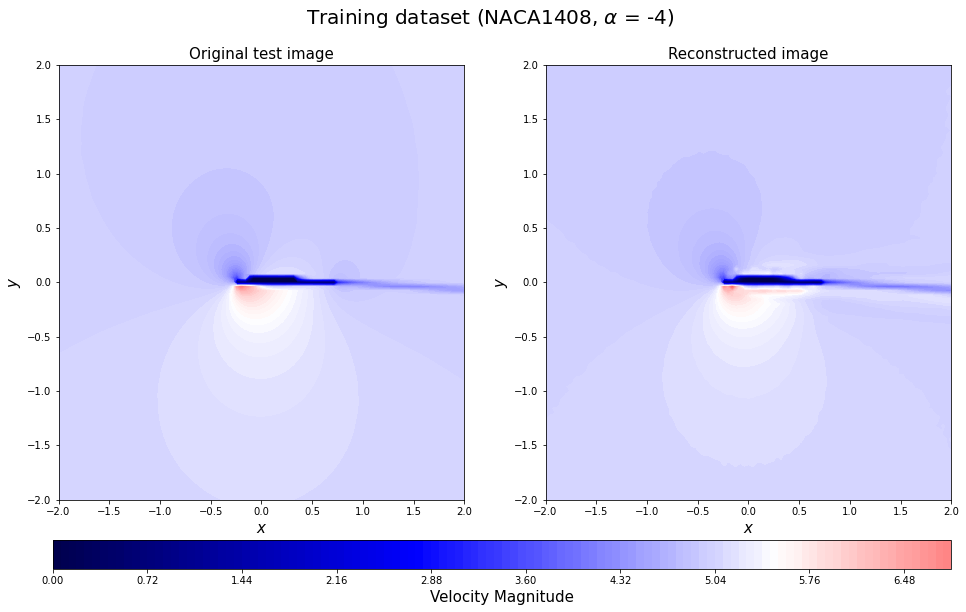

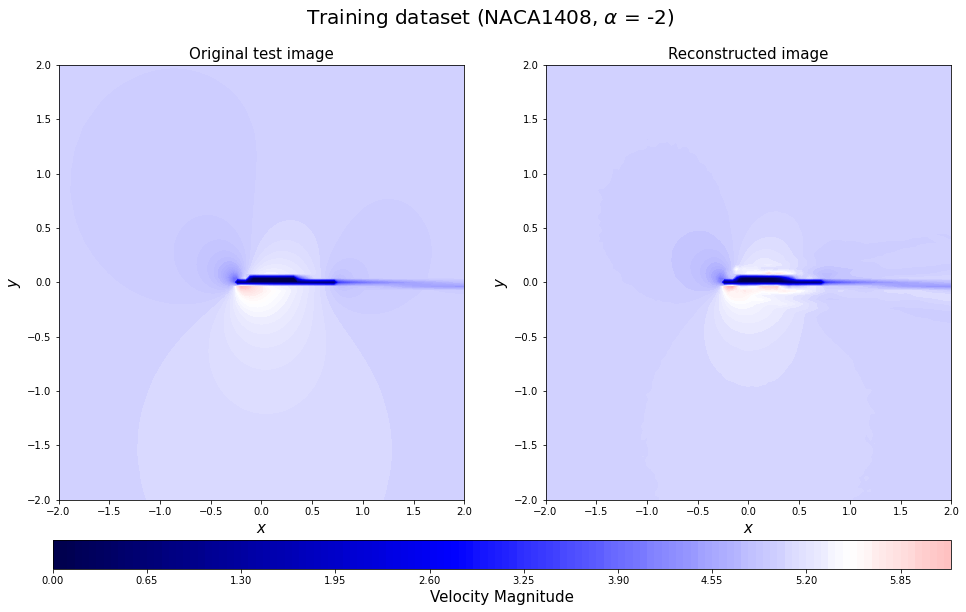

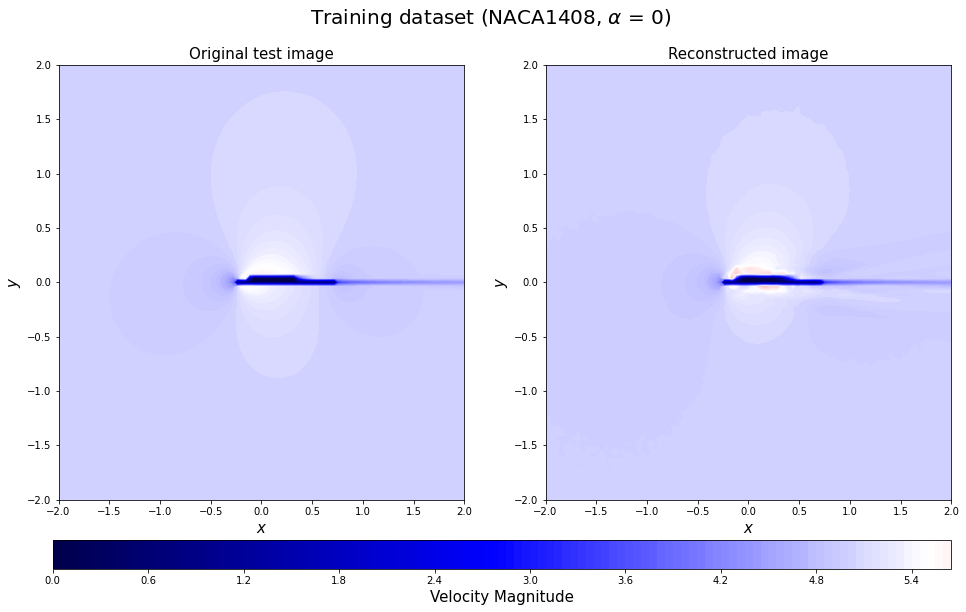

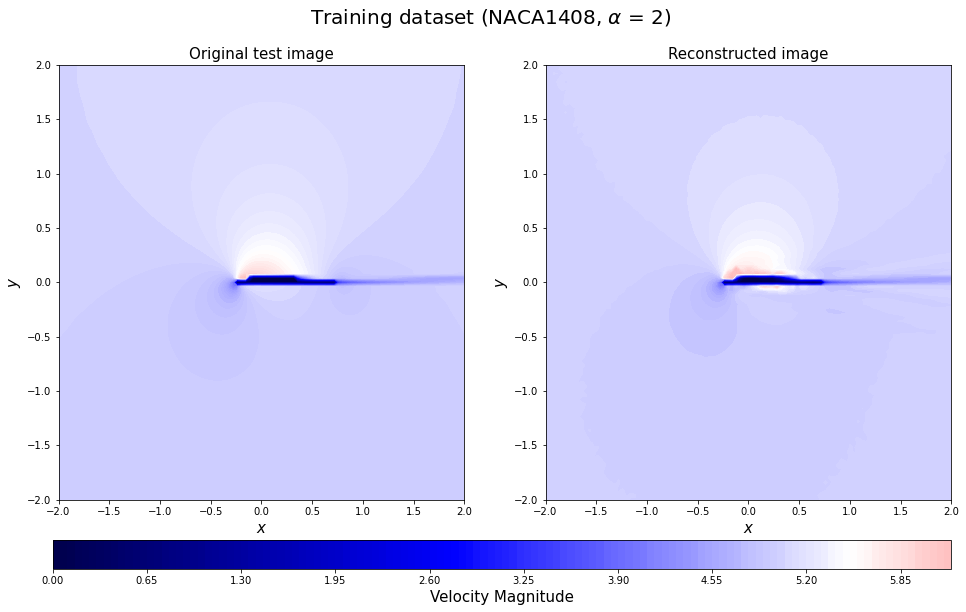

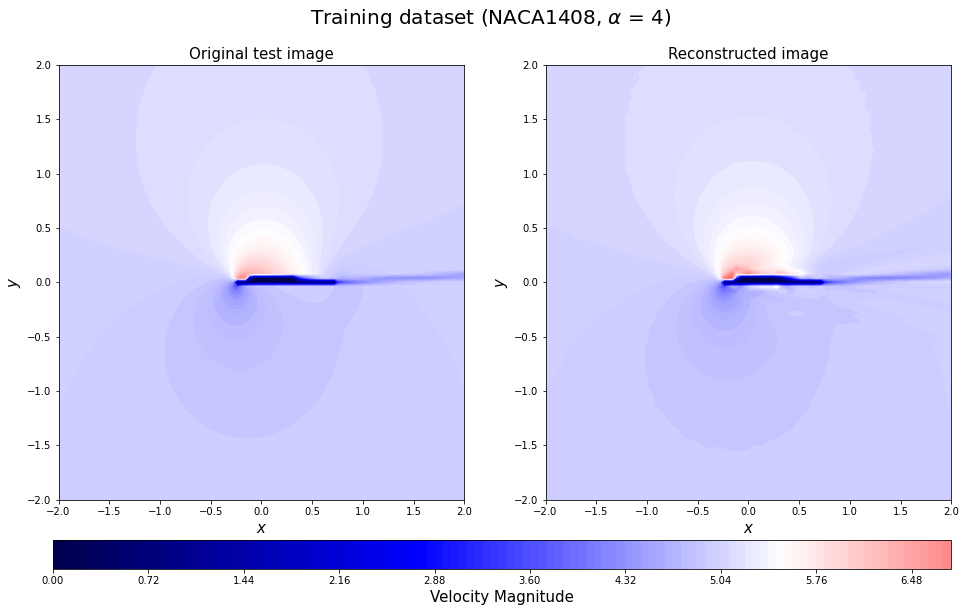

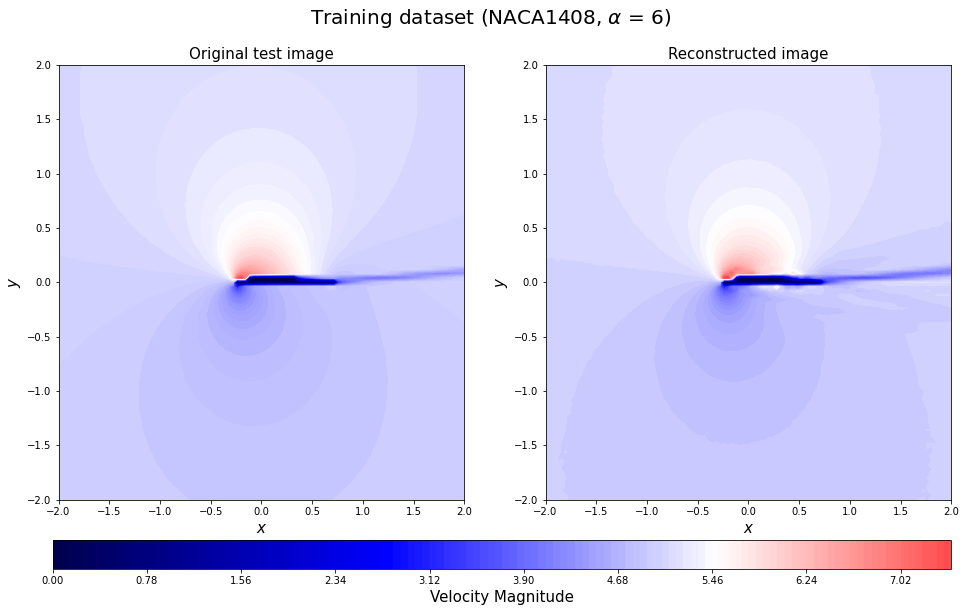

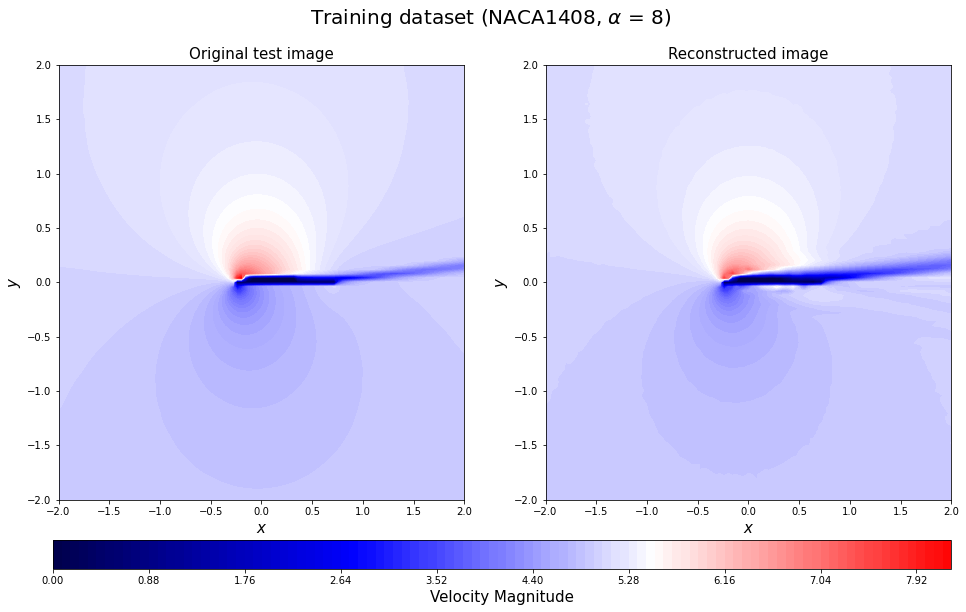

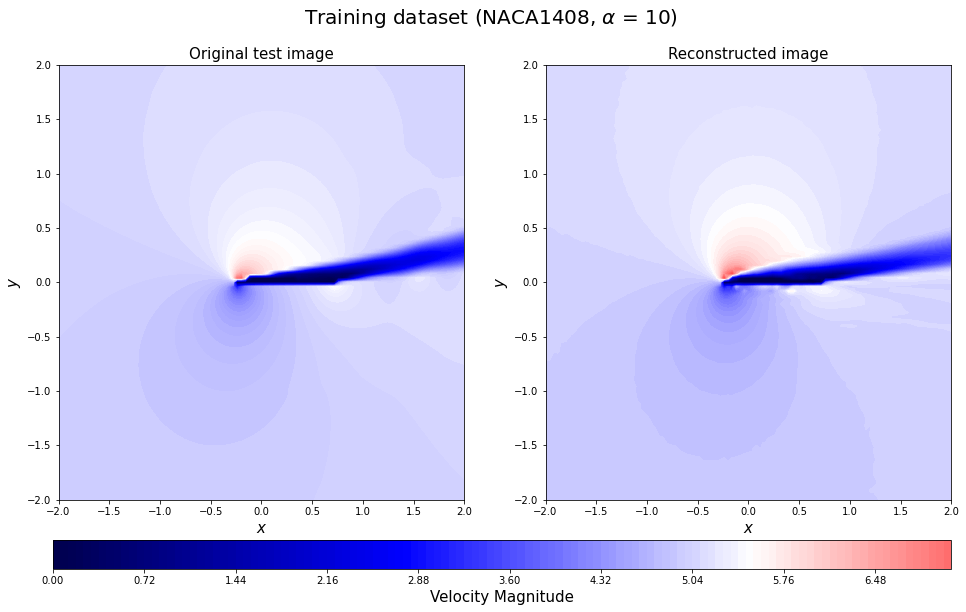

In [61]:
for c in range(0,11):
    plt.figure(figsize=(16, 8))
    y_train0_rotate = y_train[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_train[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_train0_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Training dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train[c])[3:-2], aa_train[c]),fontsize=20)
    save_fig_name = "20221019Prediction_AeroCNN-II(-10to10)(training)"+str(np.array2string(geo_train[c])[3:-2])+str(aa_train[c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

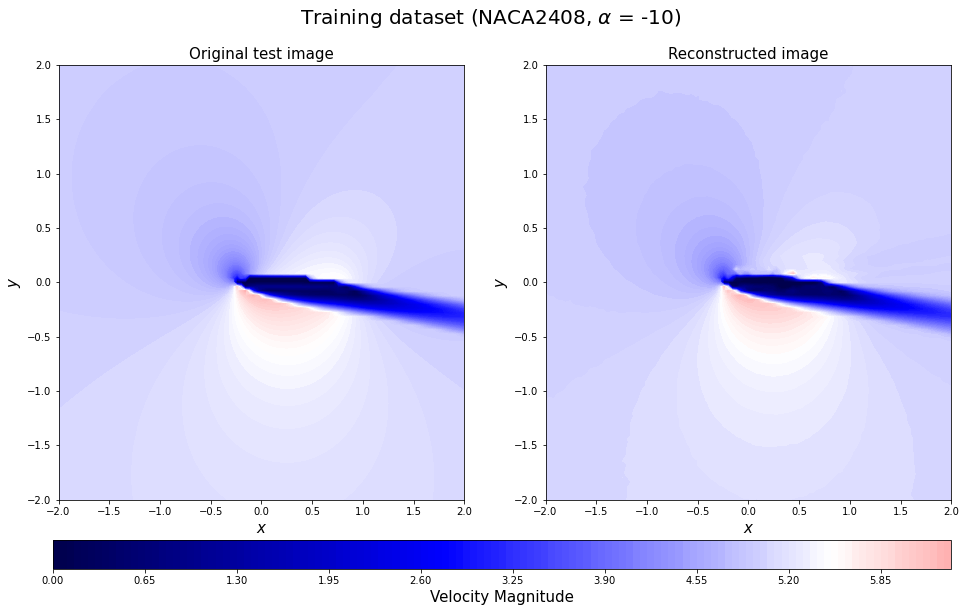

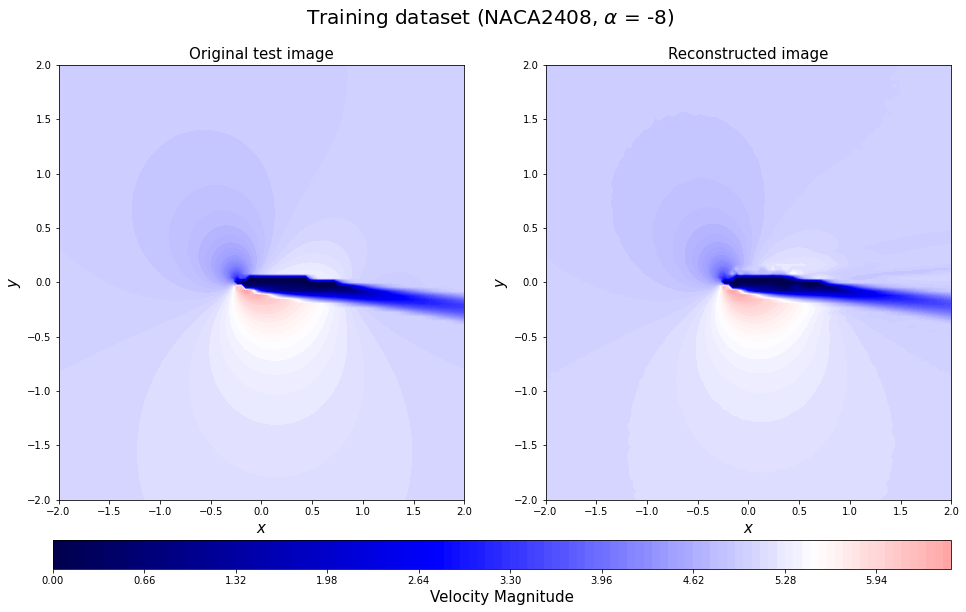

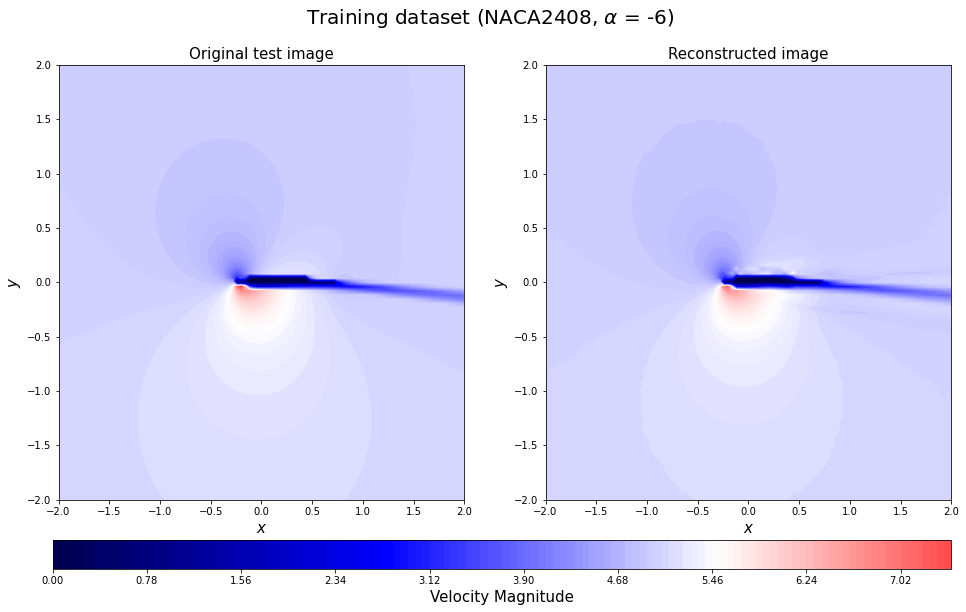

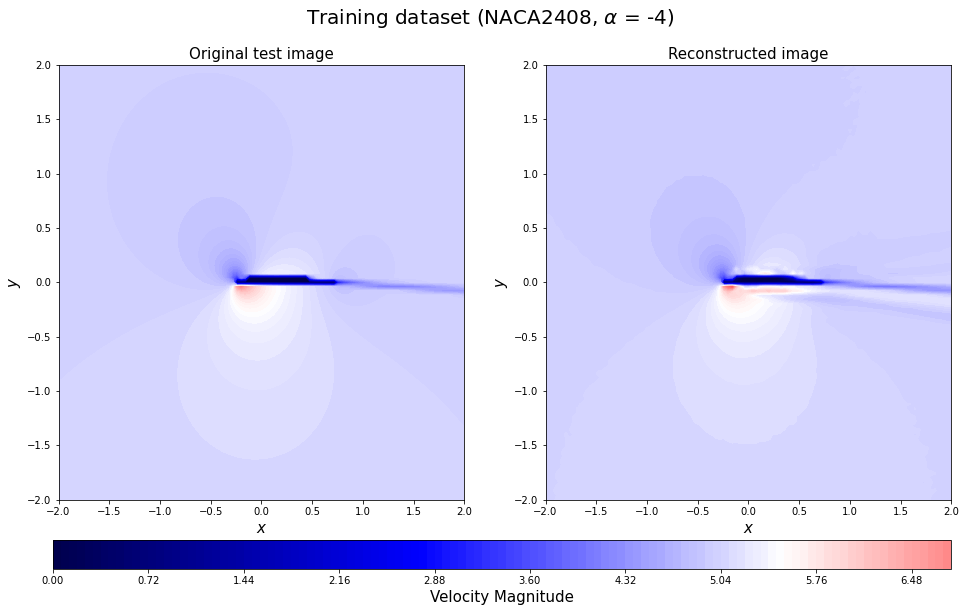

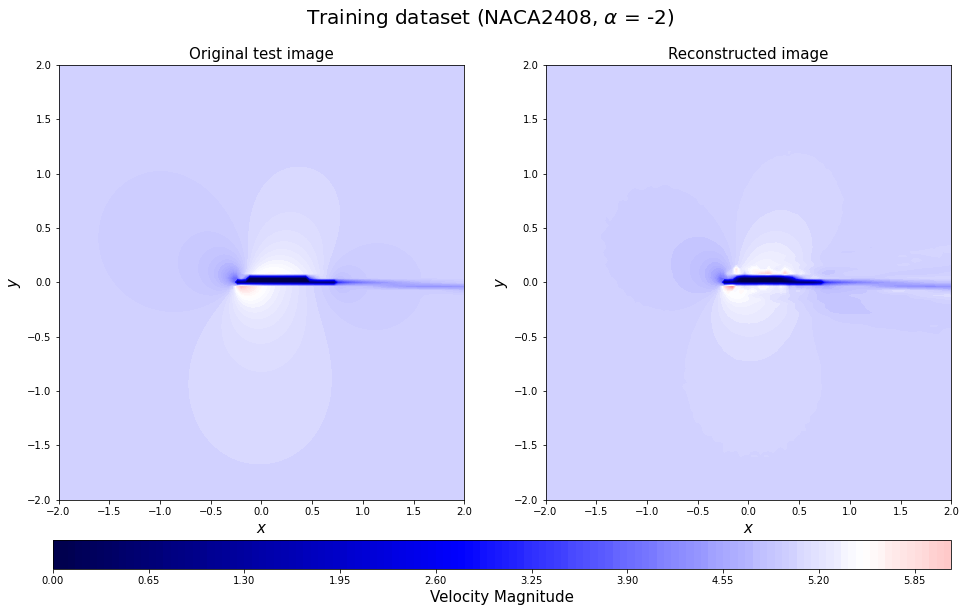

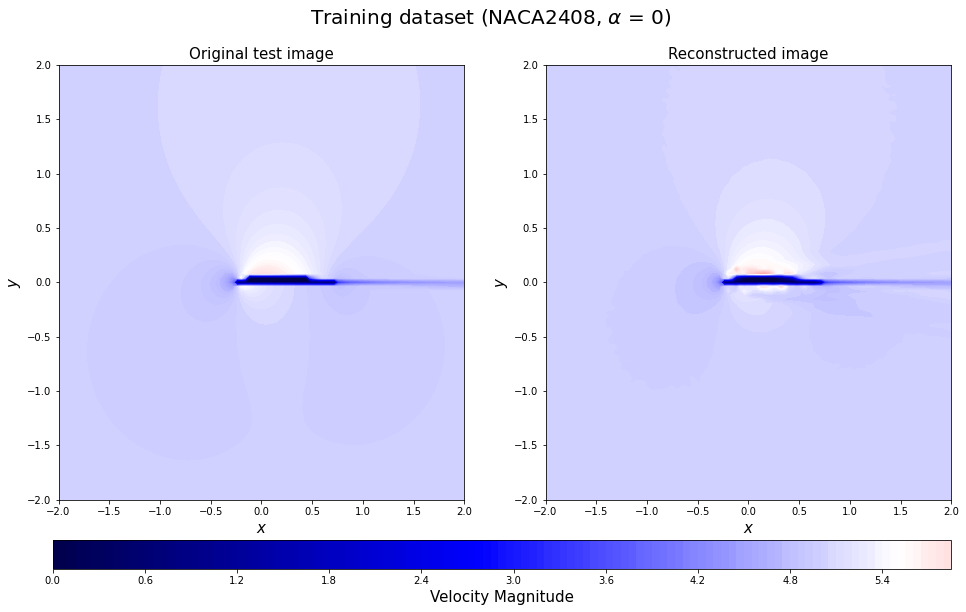

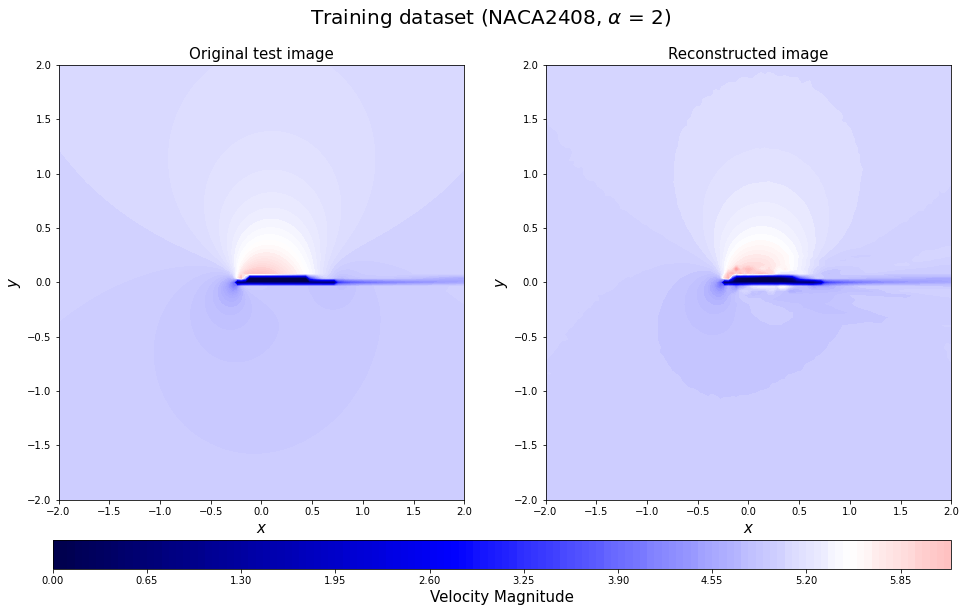

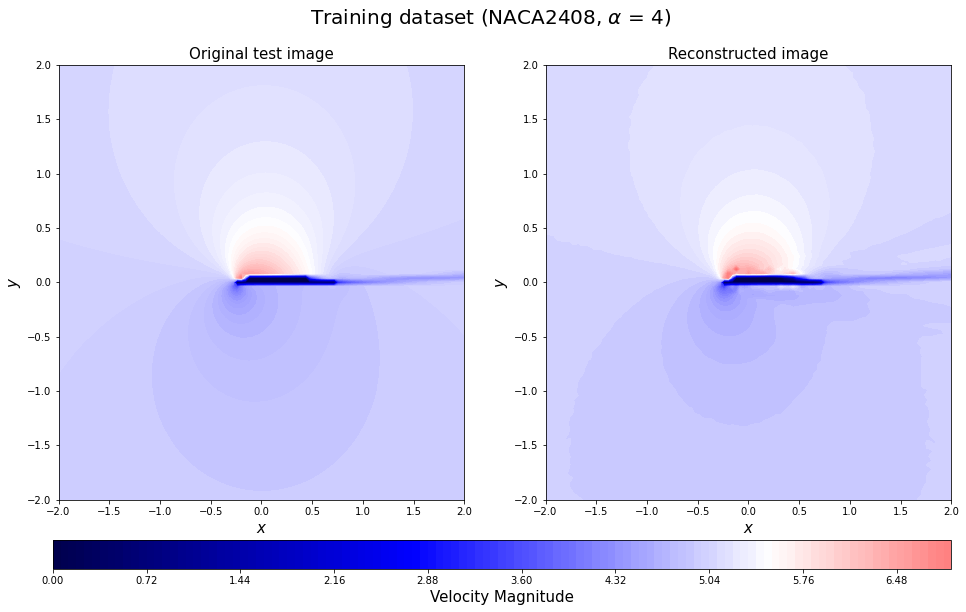

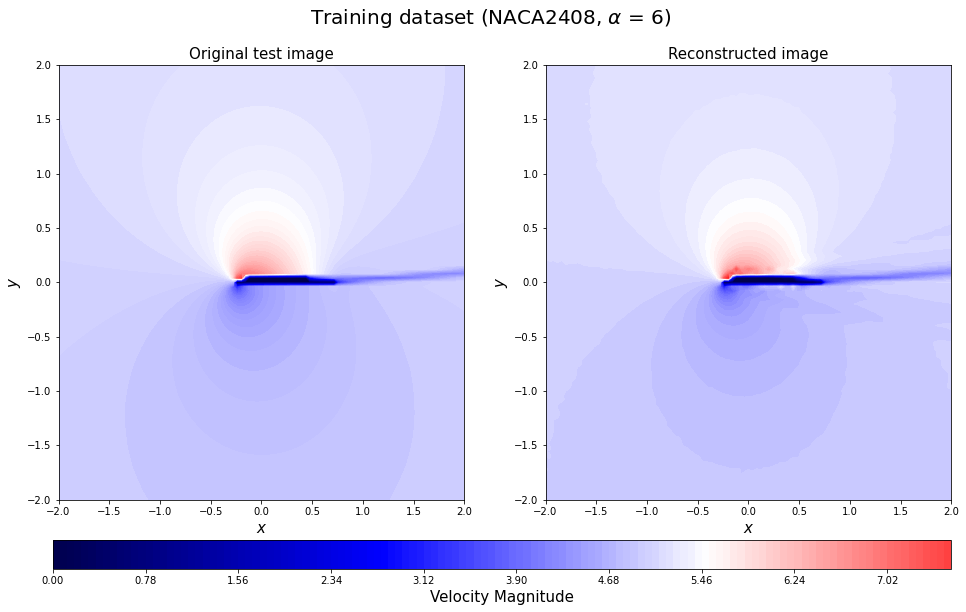

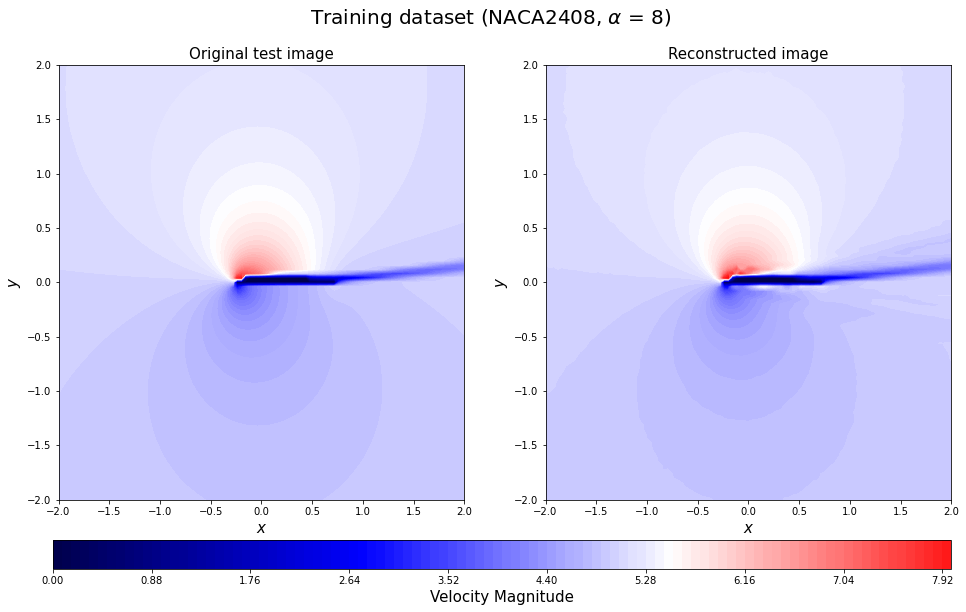

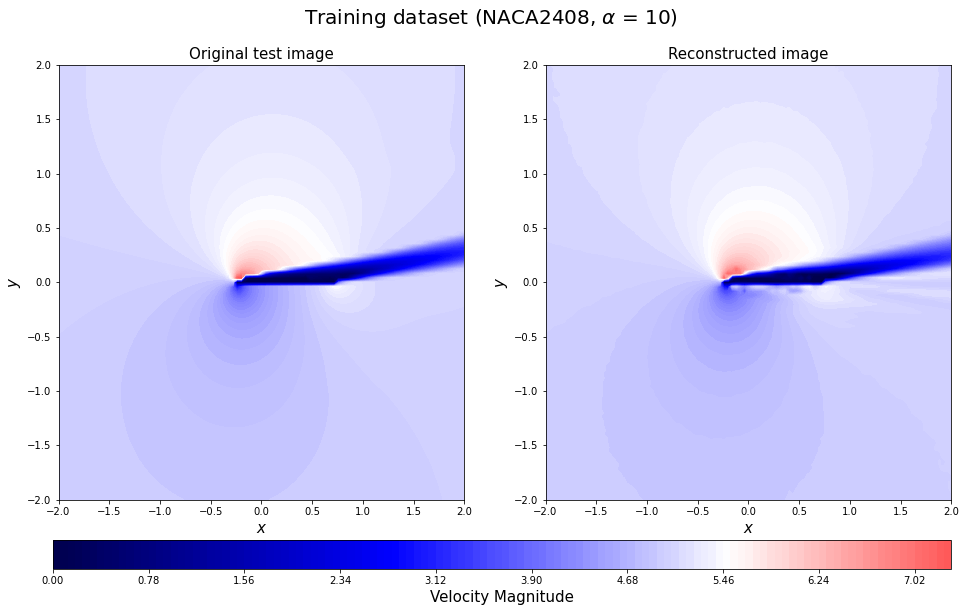

In [62]:
for c in range(0,11):
    plt.figure(figsize=(16, 8))
    y_train20_rotate = y_train[20*11+c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_train[20*11+c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_train20_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Training dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train[20*11+c])[3:-2], aa_train[20*11+c]),fontsize=20)
    save_fig_name = "20221019Prediction_AeroCNN-II(-10to10)(training)"+str(np.array2string(geo_train[20*11+c])[3:-2])+str(aa_train[20*11+c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

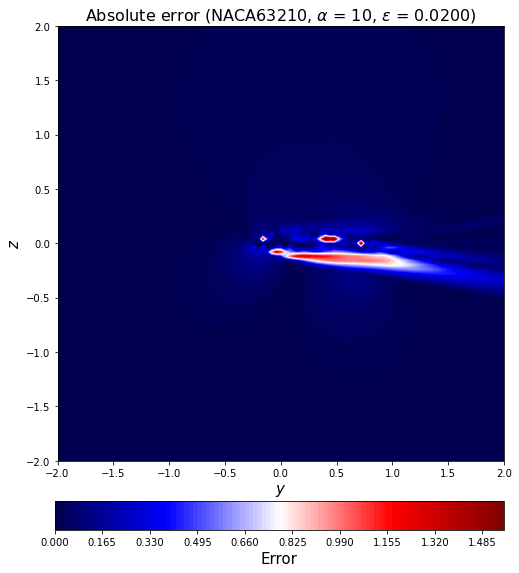

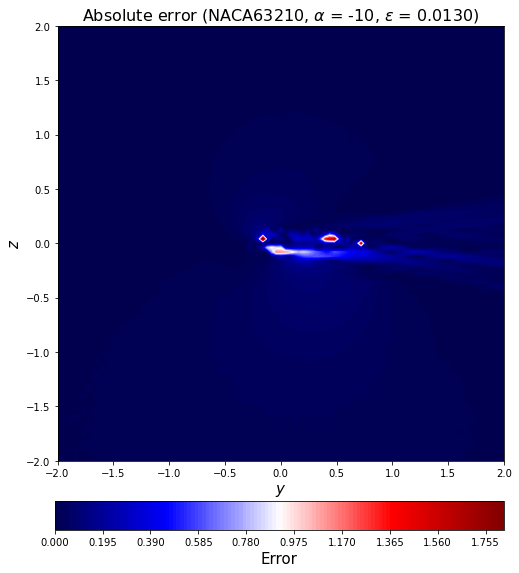

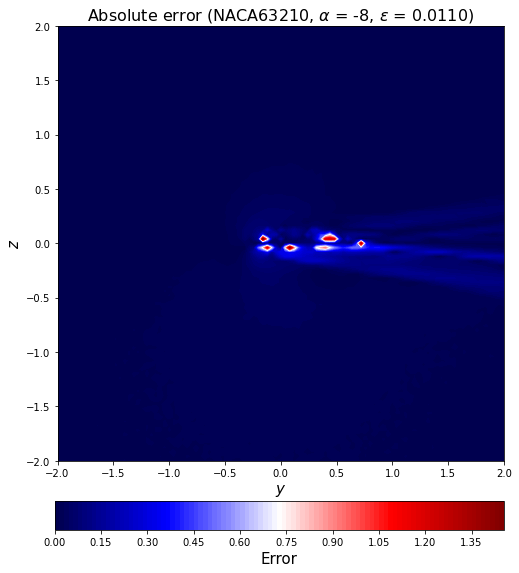

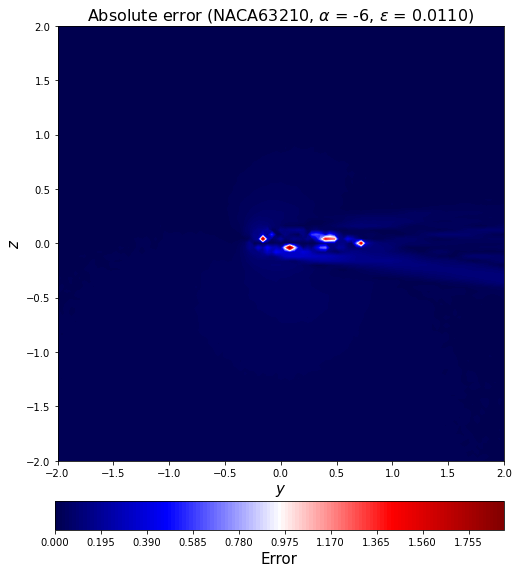

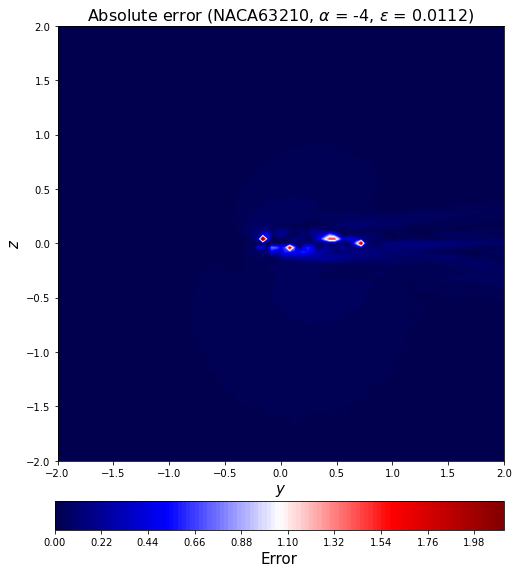

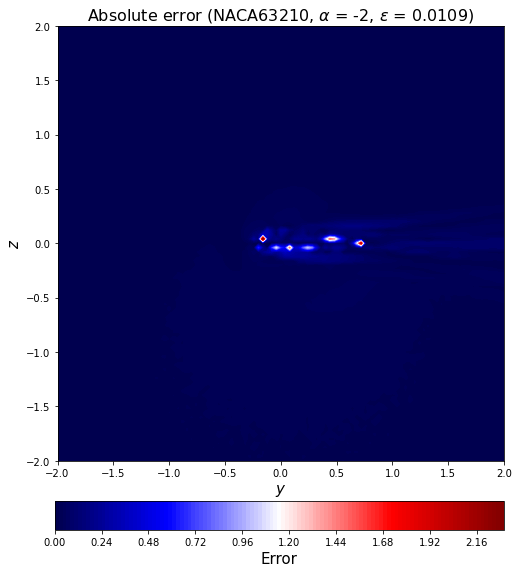

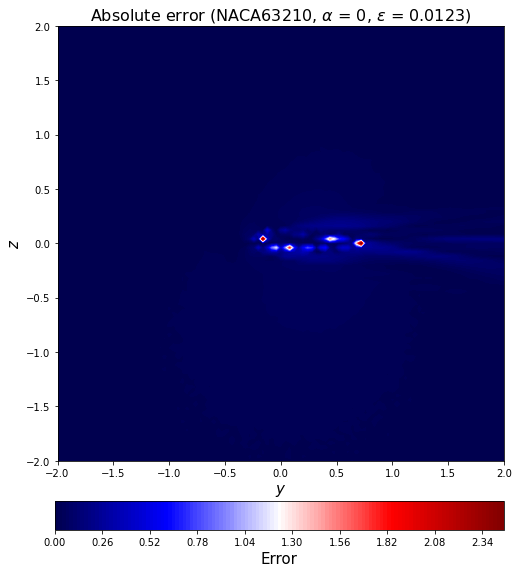

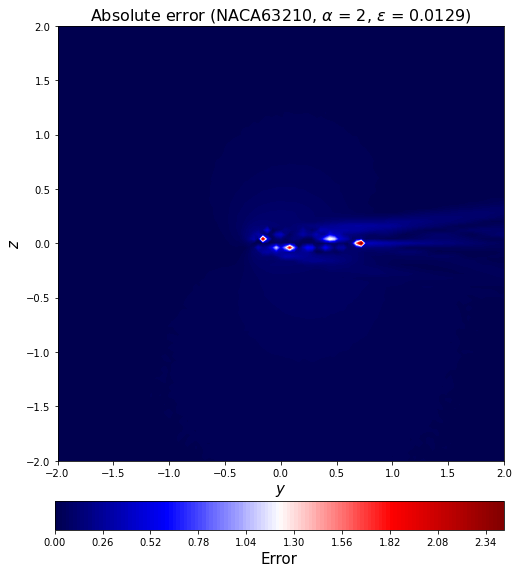

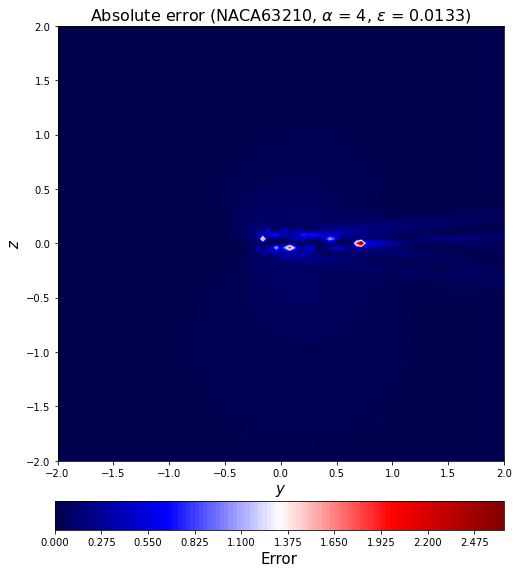

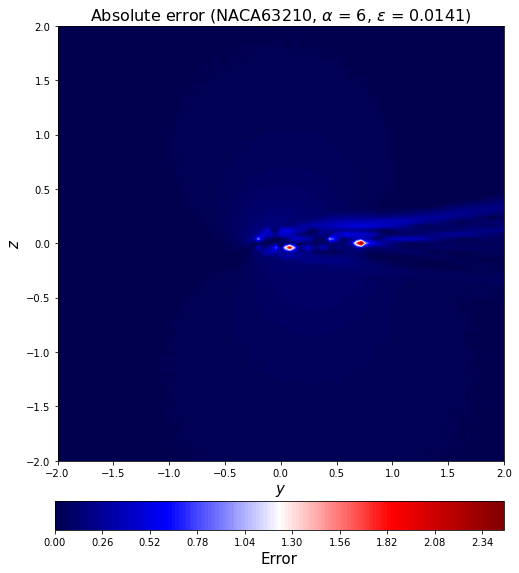

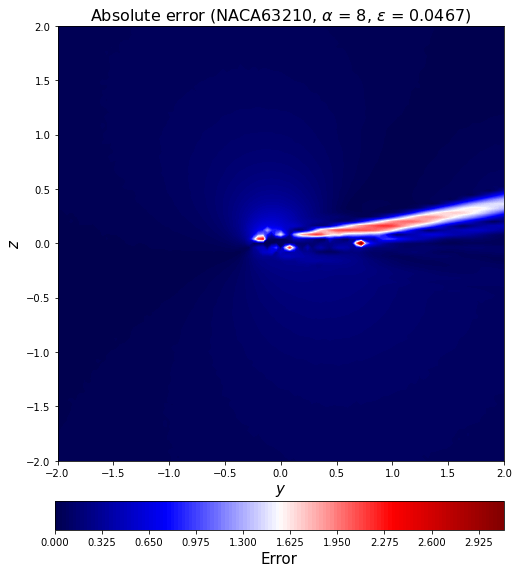

In [63]:
for c in range(0,11):
    error_test_abs2_rotate = error_test_abs[2*11+c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[2*11+c])[3:-2],
                                                                       aa_test[2*16+c], l2_error_test_list[2*11+c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    save_fig_name = "20221019PredictionError_AeroCNN-II(-10to10)(test)"+str(np.array2string(geo_test[2*11+c])[3:-2])+str(aa_test[2*11+c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

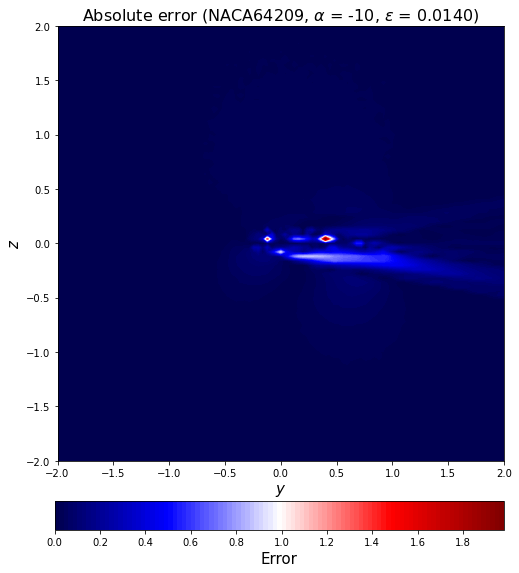

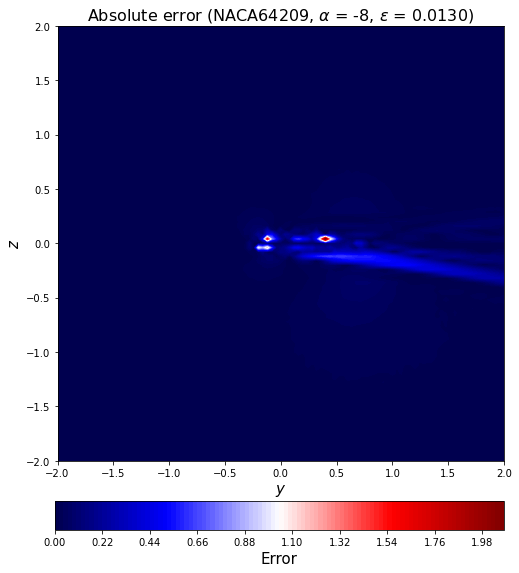

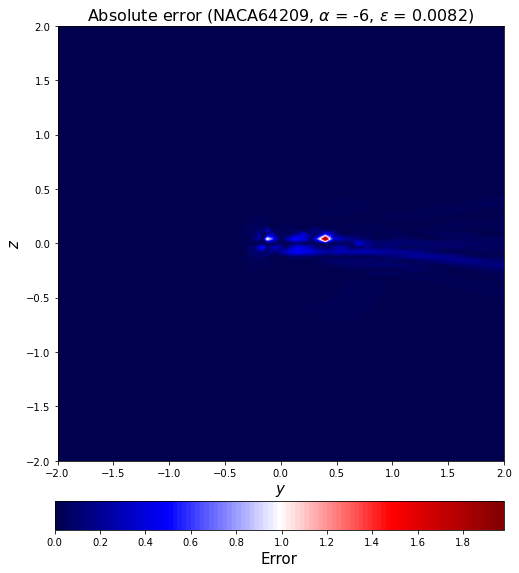

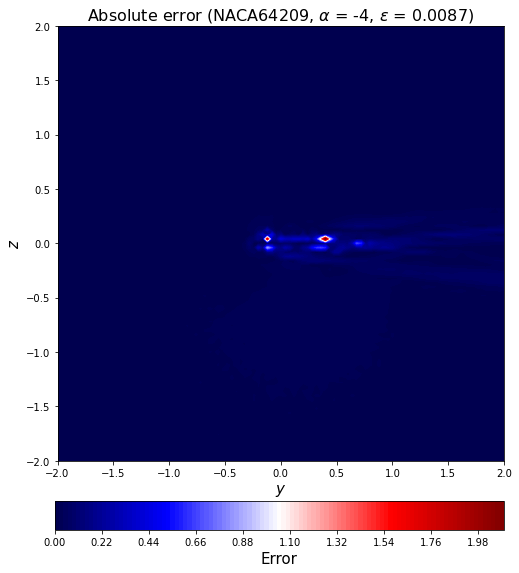

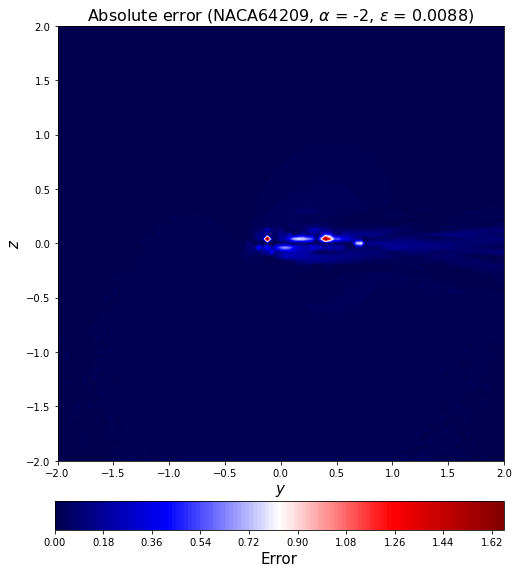

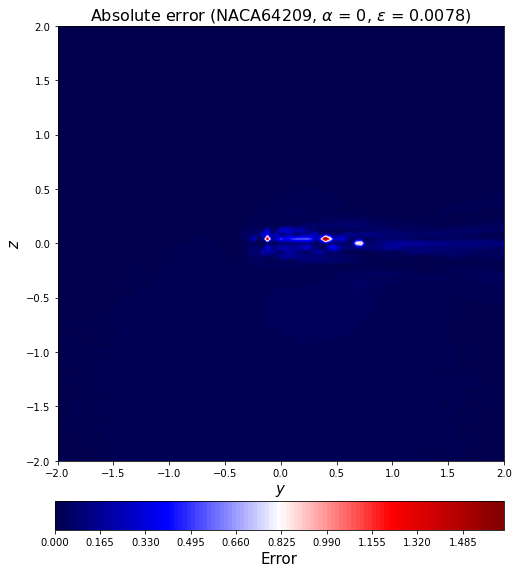

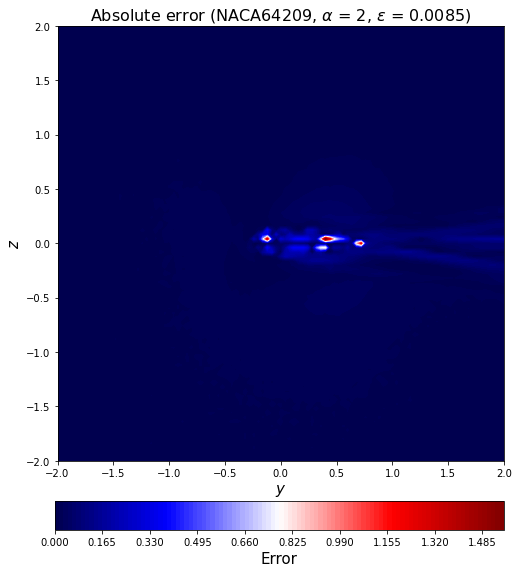

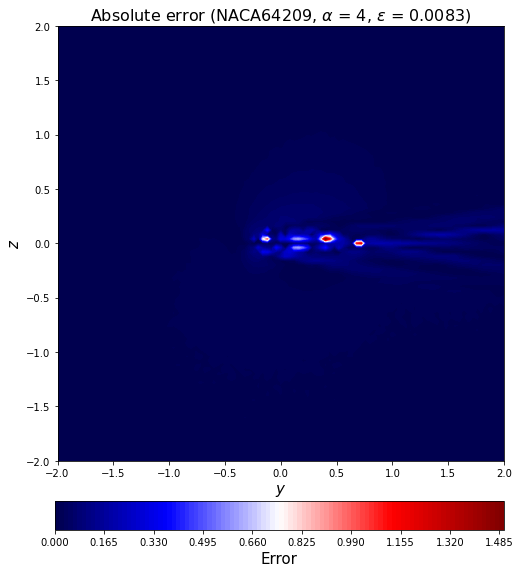

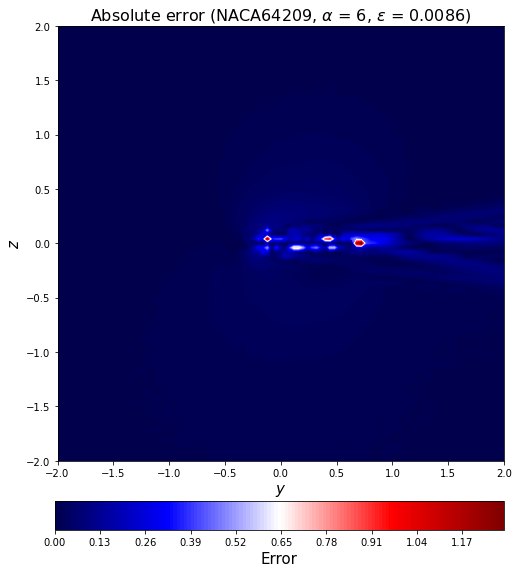

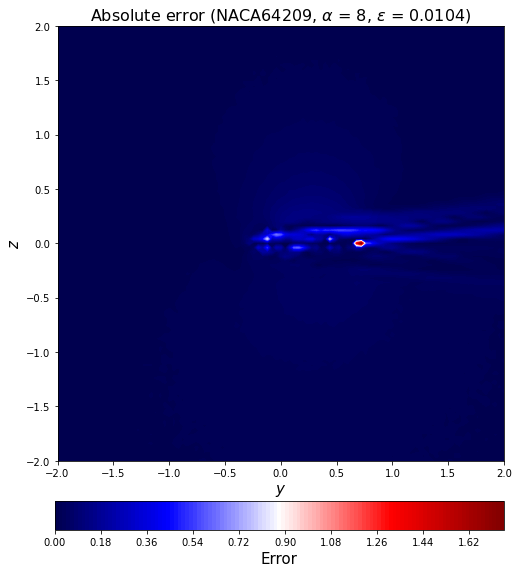

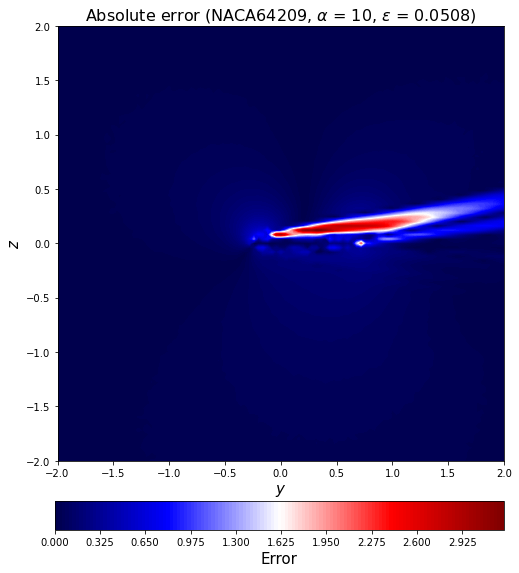

In [64]:
for c in range(0,11):
    error_test_abs2_rotate = error_test_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[c])[3:-2],
                                                                       aa_test[c], l2_error_test_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    save_fig_name = "20221019PredictionError_AeroCNN-II(-10to10)(test)"+str(np.array2string(geo_test[c])[3:-2])+str(aa_test[c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

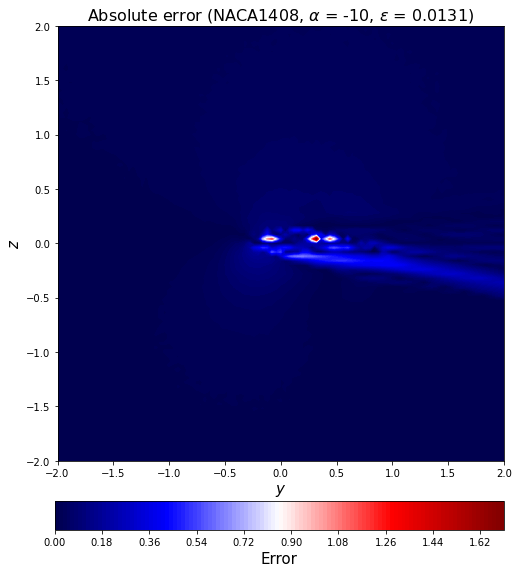

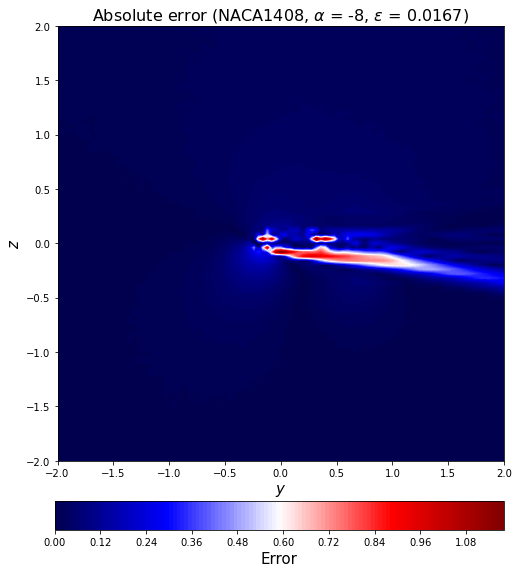

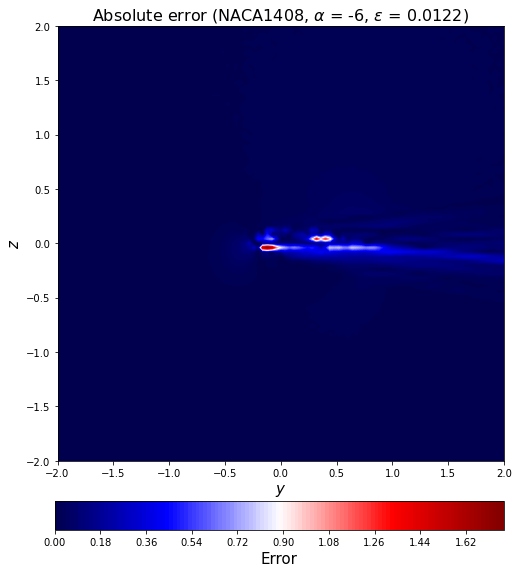

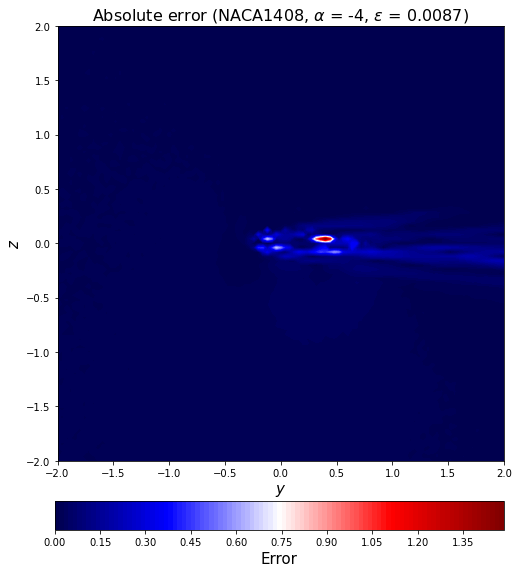

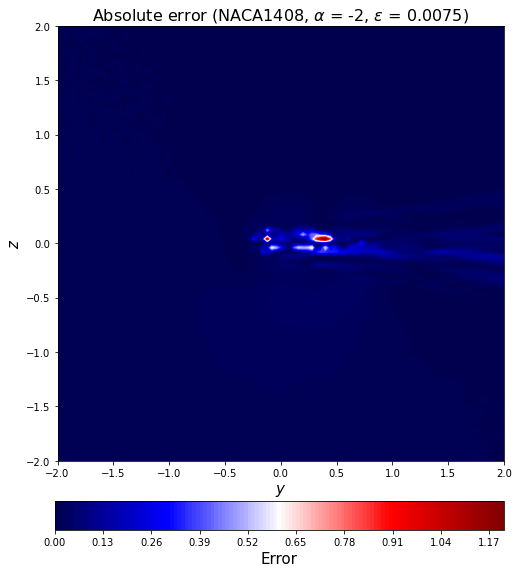

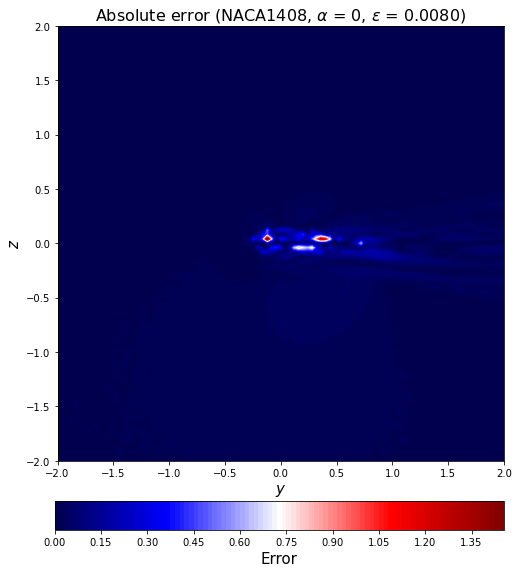

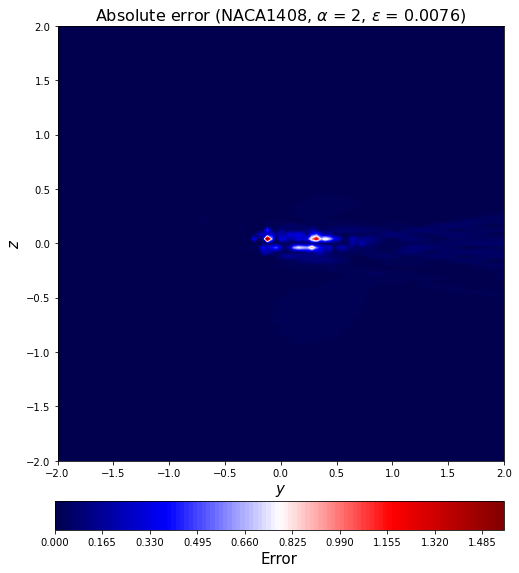

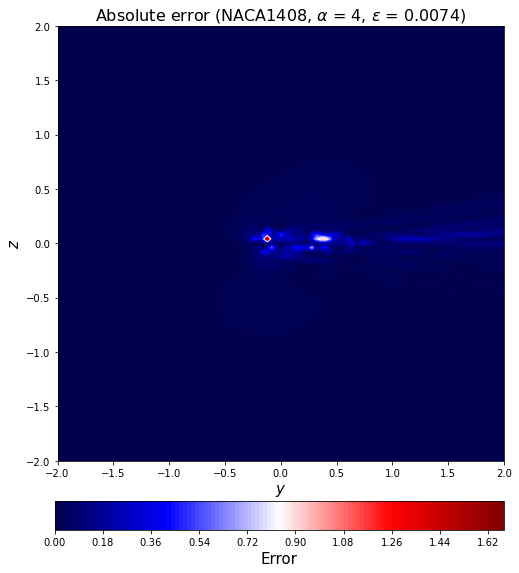

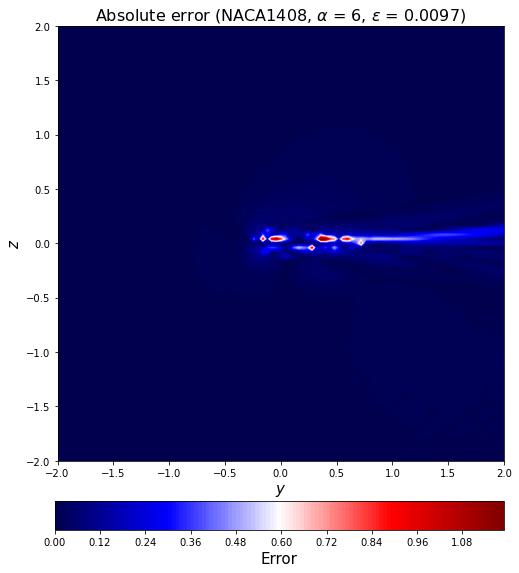

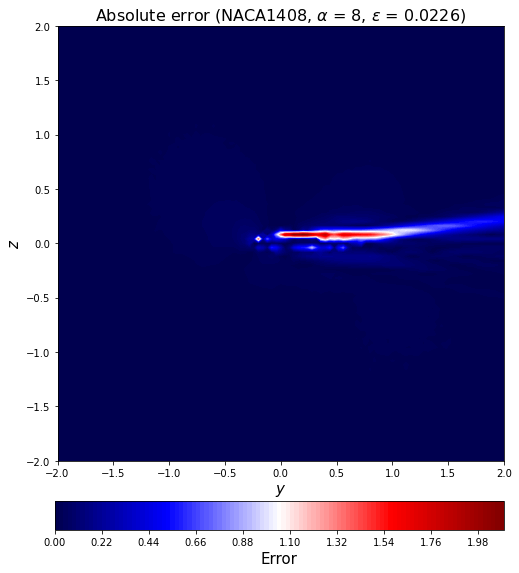

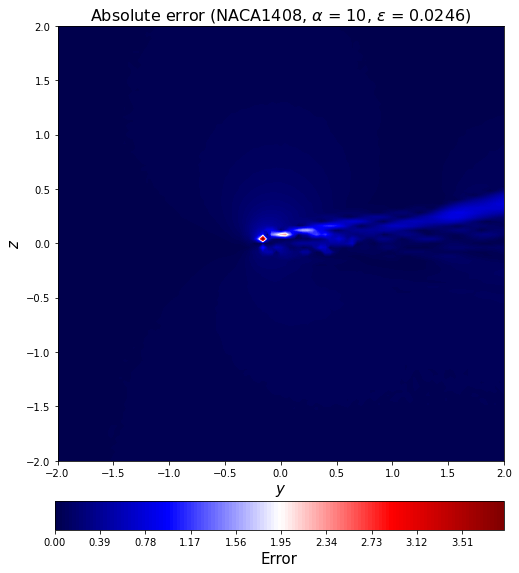

In [65]:
for c in range(0,11):
    error_train_abs2_rotate = error_train_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_train_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_train[c])[3:-2],
                                                                             aa_train[c], l2_error_train_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    save_fig_name = "20221019PredictionError_AeroCNN-II(-10to10)(training)"+str(np.array2string(geo_train[c])[3:-2])+str(aa_train[c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

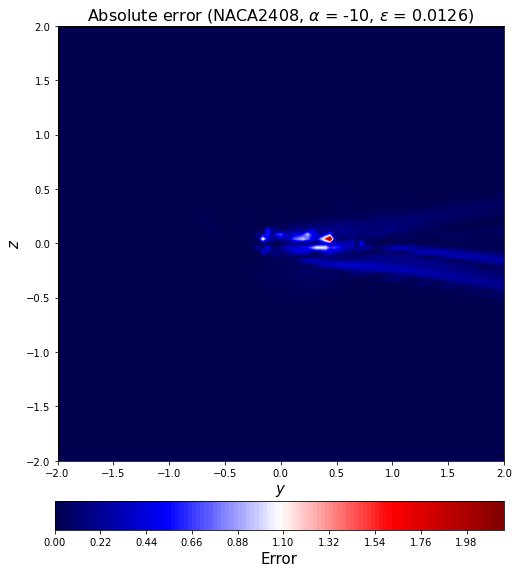

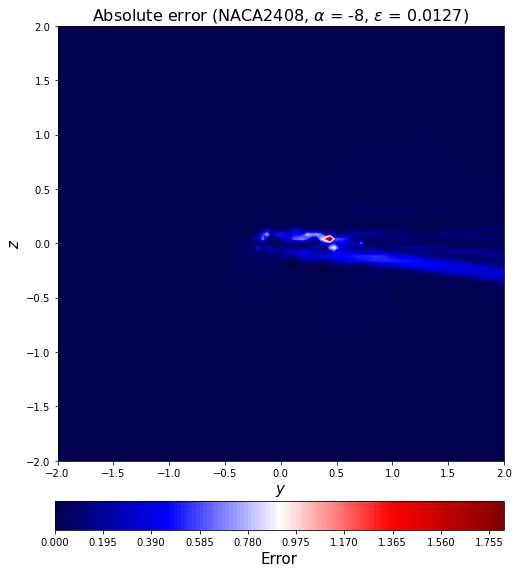

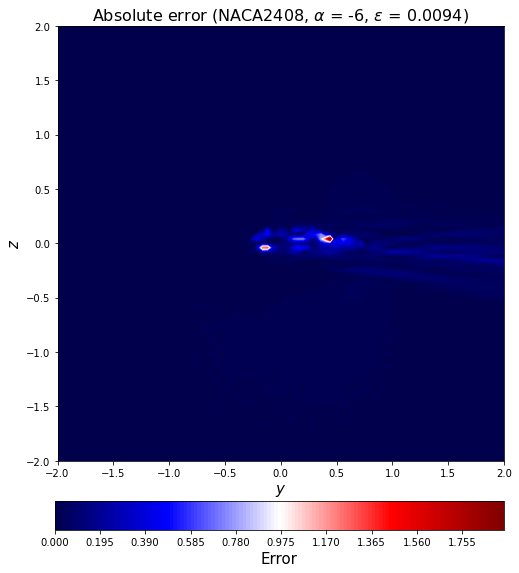

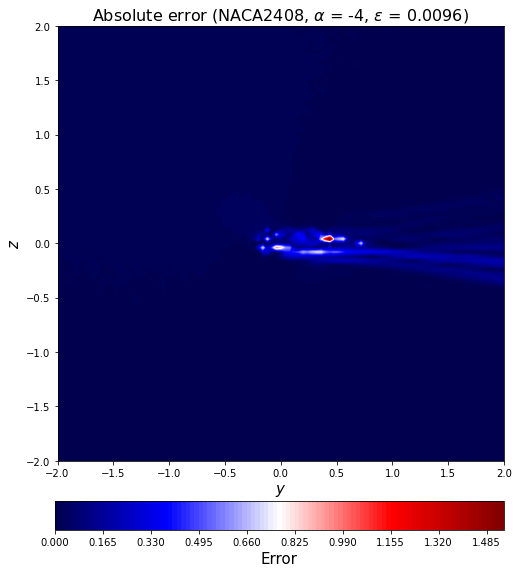

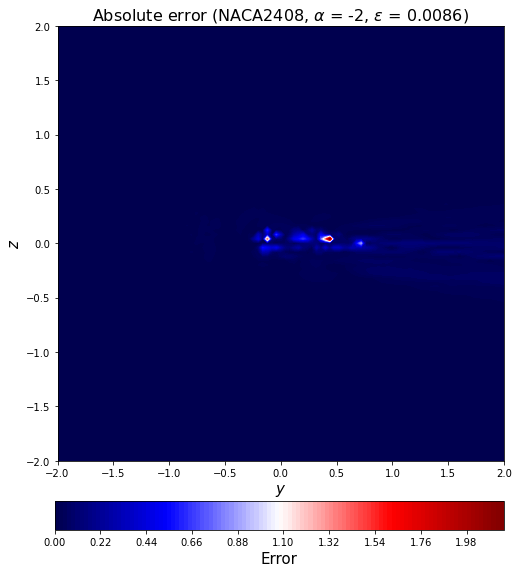

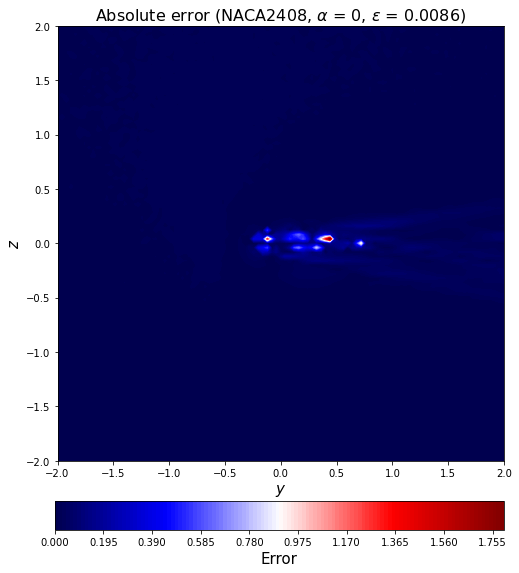

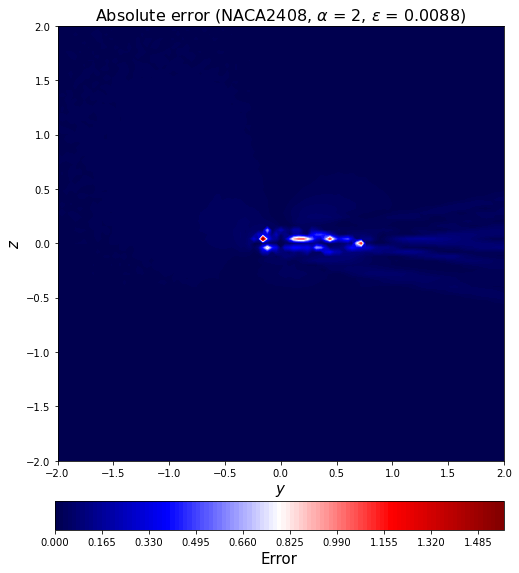

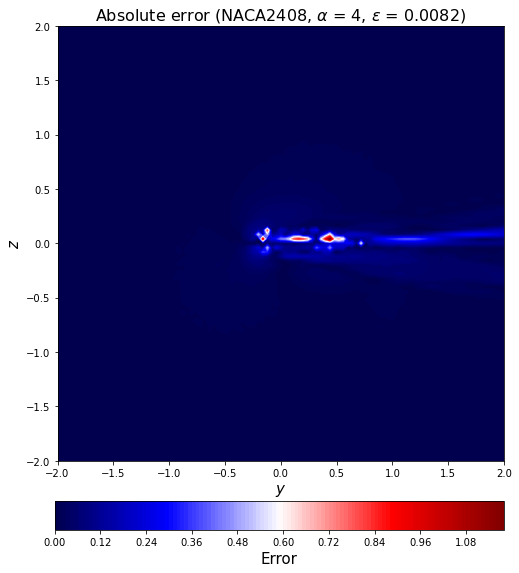

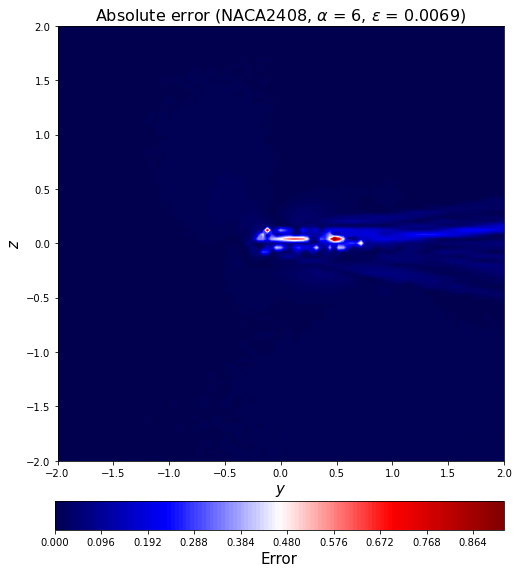

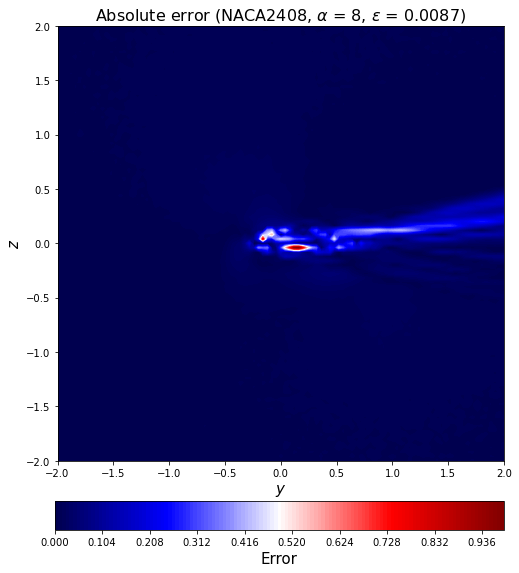

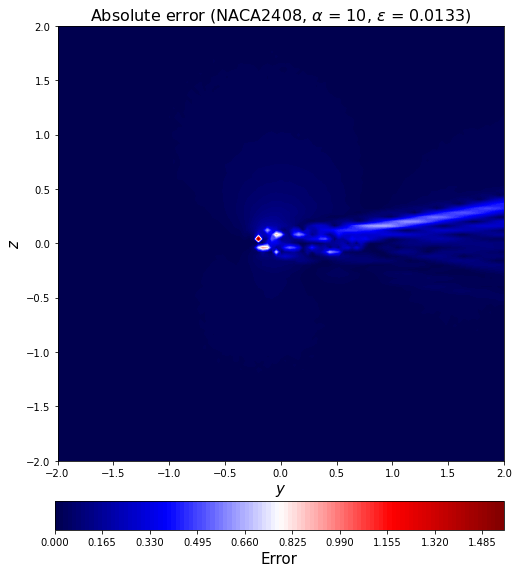

In [66]:
for c in range(0,11):
    error_train_abs2_rotate = error_train_abs[11*20+c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_train_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_train[11*20+c])[3:-2],
                                                                             aa_train[11*20+c], l2_error_train_list[11*20+c]),fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    save_fig_name = "20221019PredictionError_AeroCNN-II(-10to10)(training)"+str(np.array2string(geo_train[11*20+c])[3:-2])+str(aa_train[11*20+c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [ ]:
np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))

In [130]:
MAPE_train = (np.sum(np.abs(np.sum(y_train)-np.sum(decoded_train))) / np.abs(np.sum(y_train)))/(y_train.shape[0]/11)*100
acc_train = 1-MAPE_train

In [131]:
y_train.shape

(1386, 101, 101)

In [132]:
print(MAPE_train)
print(acc_train)

0.0015028264275322731
0.9984971735724677


In [133]:
MAPE_test = (np.sum(np.abs(np.sum(y_test)-np.sum(decoded_test))) / np.abs(np.sum(y_test)))/(y_test.shape[0]/11)*100
acc_test = 1-MAPE_test

In [134]:
print(MAPE_test)
print(acc_test)

0.024493145247494158
0.9755068547525059


In [144]:
MAPE_train_list = []
acc_train_list = []
for i in range(0, len(aa_train)):
    MAPE_train_data = (np.sum(np.abs(y_train[i]-decoded_train[i])) / np.sum(np.abs(y_train[i])))/(y_train.shape[0]/11)*100
    MAPE_train_list.append(MAPE_train_data)
    acc_train_data = 1 - MAPE_train_data
    acc_train_list.append(acc_train_data)
print(MAPE_train_list)
print(acc_train_list)

[0.004897329016383961, 0.004677227433838568, 0.003058981015207482, 0.003184830118133583, 0.0024632952599422634, 0.0026181961458295643, 0.0018596159422635526, 0.0015885338879581196, 0.002021305965557554, 0.004247257548527225, 0.009981333964714921, 0.004637699488654587, 0.0030192355078980273, 0.003290950157036063, 0.0033873129727448456, 0.002819988121763594, 0.003231121950164646, 0.003056117222533653, 0.0029728394022912785, 0.00335589061564236, 0.003844374006172486, 0.004131642277011682, 0.003463624625498112, 0.004126179184376445, 0.0036313334240589182, 0.00334445104056057, 0.0029745198018140085, 0.0034539433803745133, 0.003003492682978588, 0.002727379021696805, 0.0025724581487994564, 0.003054182594508711, 0.0036956646061458553, 0.0032156009253848637, 0.00289788150971298, 0.002682994818492647, 0.002578228649319673, 0.0024053649807819514, 0.0028142087089775545, 0.002248852029634659, 0.002240831547099845, 0.0020350602914825473, 0.0016611710528013834, 0.0028362465100625245, 0.01513215663343

In [136]:
MAPE_test_list = []
acc_test_list = []
for i in range(0, len(aa_test)):
    MAPE_test_data = (np.sum(np.abs(y_test[i]-decoded_test[i])) / np.sum(np.abs(y_test[i])))/(y_test.shape[0]/11)*100
    MAPE_test_list.append(MAPE_test_data)
    acc_test_data = 1 - MAPE_test_data
    acc_test_list.append(acc_test_data)
print(MAPE_test_list)
print(acc_test_list)

[0.06840580799067975, 0.05888405762026058, 0.041433671229302096, 0.050785053423372, 0.05053408892686195, 0.04981648775643191, 0.047326008605578354, 0.04392194629660615, 0.048201105320954285, 0.06766827219686043, 0.24097001541525379, 0.07232044191034855, 0.06494611247213887, 0.07931733790239211, 0.08996891718132974, 0.09136860232352581, 0.057597927473031295, 0.06045662240996266, 0.049180230301191036, 0.06378536599239823, 0.0674906016226499, 0.07115468802990248, 0.08896626978255409, 0.07121864983733728, 0.05459270582731539, 0.061723198819544724, 0.055479460926927855, 0.056329588679398614, 0.060421133455065175, 0.07522680370130656, 0.07758544649207845, 0.09739807863077359, 0.3116870796954432, 0.13491171358810064, 0.04561364928606394, 0.04865453959174204, 0.05634718103829804, 0.060998366395461995, 0.03822219611773812, 0.051630498915972524, 0.032653527988884934, 0.04467046834349584, 0.06854532389652244, 0.14198529150059624, 0.1868880280636348, 0.09822561185654738, 0.059111064609588516, 0.06

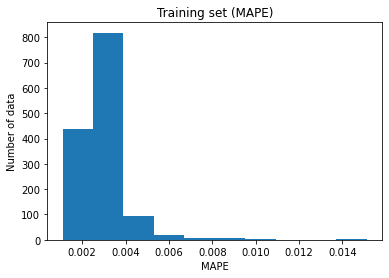

In [137]:
plt.hist(MAPE_train_list)
plt.title('Training set (MAPE)')
plt.ylabel('Number of data')
plt.xlabel('MAPE')
plt.show()

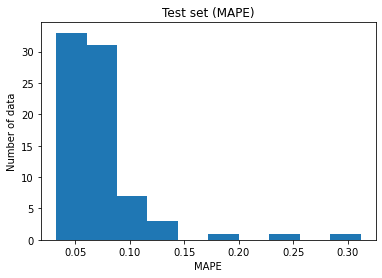

In [138]:
plt.hist(MAPE_test_list)
plt.title('Test set (MAPE)')
plt.ylabel('Number of data')
plt.xlabel('MAPE')
plt.show()

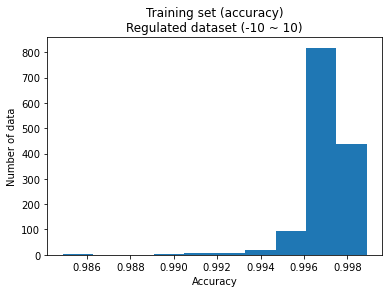

In [147]:
plt.hist(acc_train_list)
plt.title('Training set (accuracy)\nRegulated dataset (-10 ~ 10)')
plt.ylabel('Number of data')
plt.xlabel('Accuracy')
plt.show()

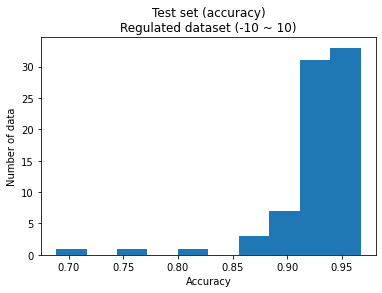

In [148]:
plt.hist(acc_test_list)
plt.title('Test set (accuracy)\nRegulated dataset (-10 ~ 10)')
plt.ylabel('Number of data')
plt.xlabel('Accuracy')
plt.show()